# Molecular Properties Prediction
Autor: Hyunwook Paul Shin

<img src="Image/molecules.png" width="80%" height="80%">

## 1. Overview

This notebook contains the steps of solving the molecular properties prediction involving the molecular structural data. The aim of the project is to create a model that can provide the accurate prediction on the target variable, scalar coupling constant. Since this is a prediction on the continous quantity output, the problem is defined as the regression problem. Then, the metrics are set as R-squared score, root mean squared error, and mean absolute error to evaluate the regression model: goal is to enhance the R2 score while maintaining the low error values. After performing multiple modeling, the Random Forest Regression is selected as the best model. 

## 2. Business Problem

Nuclear Magnetic Resonance (NMR) is a core technique used to understand the structure and interactions of the molecules and proteins. NMR is being utilized by the researchers in pharmaceutical and chemical field worldwide. The NMR performance is largely dependent on the accurate prediction on the variable, scalar coupling constant (SCC). 

SCC is the feature that provides information on the connectivity of chemical bonds which is used to explain the interaction between the molecules in NMR. However, the constraint in SCC calculation limits the application of this technique; the calculation length takes from days to even weeks for one molecule when the structural information of the molecule is an input and the cost of calculation is expensive.

Therefore, creating a model that can accurately predict the SCC will allow the NMR to be applicable for research in daily basis. The model will allow the phamceutical researchers to gain insight on how the molecular structure affects the properties and behavior faster and cheaper, and accelerate the innovation in inventing and designing new drugs.


### Stakeholder
Pharmaceutical Researchers
 
### Goal 
Develop a regression model that predicts the scalar coupling constant from the structural information of the molecule. 

### Metrics
For evaluation, we will look at the following metrics:
- R2 Score
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)

Better model will show larger R2 score while showing smaller RMSE and MAE values.

## 3. Data Understanding

The dataset used for this prediction modeling was sourced from https://www.kaggle.com/c/champs-scalar-coupling/data. Following is the description of the dataset we will be using for the analysis.

- train.csv
    - the training set, where the first column (molecule_name) is the name of the molecule where the coupling constant originates (the corresponding XYZ file is located at ./structures/.xyz), the second (atom_index_0) and third column (atom_index_1) is the atom indices of the atom-pair creating the coupling and the fourth column (scalar_coupling_constant) is the scalar coupling constant that we want to be able to predict

- structures.csv 
    - this file contains the same information as the individual xyz structure files, but in a single file

Provided test.csv will not be used for analysis since it does not provide target variable, and, therefore, it cannot be used to check the accuracy of the result of the model. Instead, we will split the train.csv into train, test, and validation set. 

Before starting the data analysis, lets import the libraries and tools that will be used for the whole process.

In [1]:
#!pip install lightgbm

In [2]:
#!pip install CatBoost

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, BatchNormalization 
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping


import warnings
warnings.filterwarnings("ignore")

### 3.1 Load Dataset

Lets load the train.csv and structures.csv and check the contents.

In [104]:
# Import the data
# goal: predict scalar_coupling_const by its structure
# We will use train set and structures
train_df = pd.read_csv('Data/train.csv')
structures_df = pd.read_csv('Data/structures.csv')

In [105]:
# Observe traindf
print('Data Shape')
print(train_df.shape)
print('')
print('Number of Unique Entries')
print(train_df.nunique())
print('')
print('List of Columns')
print(train_df.columns)
train_df.head()

Data Shape
(4659076, 6)

Number of Unique Entries
id                          4659076
molecule_name                 85012
atom_index_0                     28
atom_index_1                     29
type                              8
scalar_coupling_constant    2183446
dtype: int64

List of Columns
Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant'],
      dtype='object')


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [106]:
# Observe structures_df
print('Data Shape')
print(structures_df.shape)
print('')
print('Number of Unique Entries')
print(structures_df.nunique())
print('')
print('List of Columns')
print(structures_df.columns)
structures_df.head()

Data Shape
(2358875, 6)

Number of Unique Entries
molecule_name     130789
atom_index            29
atom                   5
x                2358802
y                2358808
z                2358792
dtype: int64

List of Columns
Index(['molecule_name', 'atom_index', 'atom', 'x', 'y', 'z'], dtype='object')


,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


### 3.2 Exploratory Data Analysis (EDA)

We will check the distribution of the features in this section.

#### Scalar Coupling Constant (Target)

Text(0, 0.5, 'Counts')

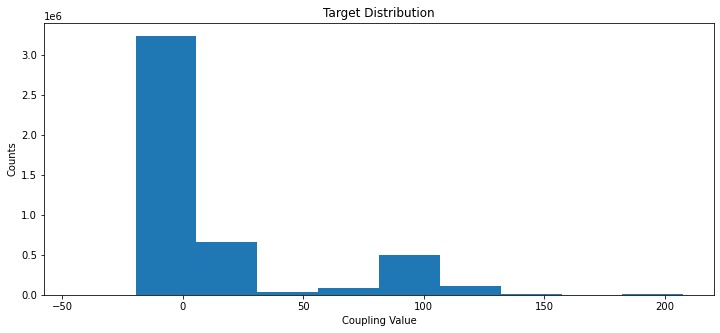

In [107]:
# Check the Distribution of Target Variable
fig, ax = plt.subplots(figsize=(12,5))

ax.hist(train_df['scalar_coupling_constant'])
ax.set_title('Target Distribution')
ax.set_xlabel('Coupling Value')
ax.set_ylabel('Counts')

Target variable distributes from -50 to 250. It is imbalanced: Most of the variables are concentrated between -50 to 50. This target variable seems to have right-skewed distribution.

However, since we are dividing up the dataset into subset, normally ditributing the data for original train_df might not positively affect the result. If we are normalizing the target variable, we have to normalize it after creating the subset. 

#### Types of Bond

Text(0, 0.5, 'Counts')

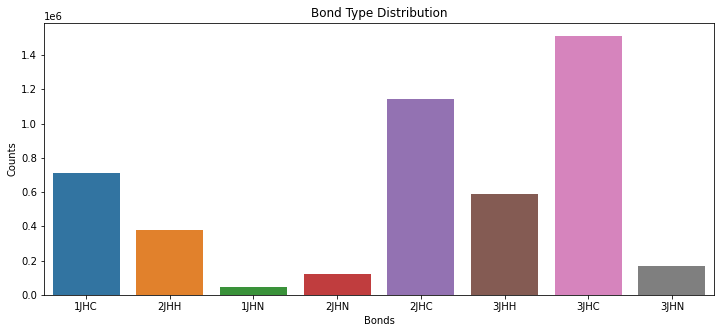

In [110]:
# Check the type of bonds
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.countplot(x='type', data=train_df)
ax.set_title('Bond Type Distribution')
ax.set_xlabel('Bonds')
ax.set_ylabel('Counts')

Multiple bond type might cause the trouble later on the modeling. We will create a subset based on each bond type in later part.

#### Atom Index

Text(0, 0.5, 'Counts')

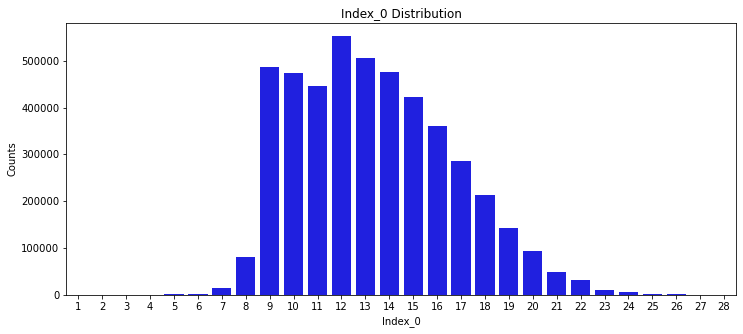

In [111]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.countplot(x='atom_index_0', data=train_df, color = 'blue')
ax.set_title('Index_0 Distribution')
ax.set_xlabel('Index_0')
ax.set_ylabel('Counts')

Text(0, 0.5, 'Counts')

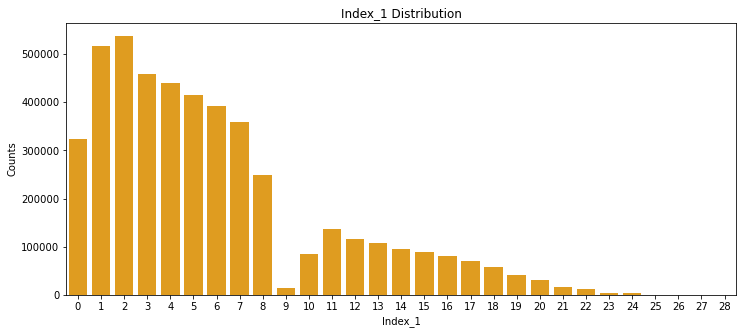

In [112]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.countplot(x='atom_index_1', data=train_df, color = 'orange')
ax.set_title('Index_1 Distribution')
ax.set_xlabel('Index_1')
ax.set_ylabel('Counts')

We can see that the Index_0 has its highest count between 9 and 17~18, while Index_1 has its highest count between 0 and 8. Although it is skewed, this is rather a categorical column than numerical column, therefore, log transformation is not needed. 

Text(0, 0.5, 'Counts')

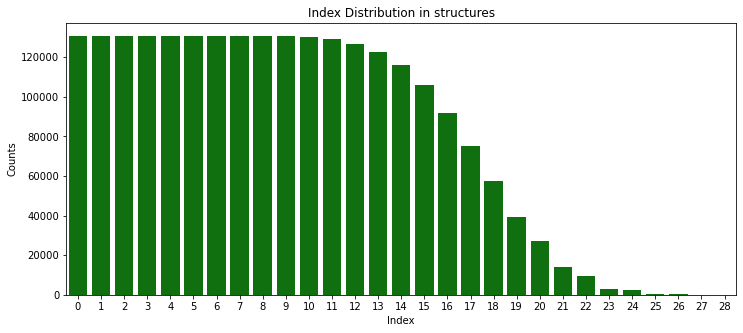

In [113]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.countplot(x='atom_index', data=structures_df, color = 'green')
ax.set_title('Index Distribution in structures')
ax.set_xlabel('Index')
ax.set_ylabel('Counts')

In structures_df, atom_index has highest count between 0 and 10 and slowly reduces after on.

Atomic index is a key column when merging the dataframes.

### 3.3 Feature Engineering

In this section, we will:
- merge train_df and structures_df
- create new features, such as distance and angle of the bond
- check the multicollinearity of each columns

#### Merge Train and Structure

This merging technique has been sourced from: https://www.kaggle.com/inversion/atomic-distance-benchmark.

As we can see from EDA for the atom_index, train_df has two atom_index columns, while the structures_df has only one. This is because train_df contains the infromation on the bond between two atoms, and structures_df contains the information on the position of one atom inside the molecule. Therefore, merging process has to be done twice: once for each atom in the bond. Since the same preprocess is being used twice, we will create a function to speed up the process.

In [114]:
def map_atom_info(df, atom_idx):
    '''
    This function merges the input df with the structures information df based on atom_idx input.
    There are two atom indexes in the df: 0 and 1. 
    Structure information will be merged to input df, and the contents will be renamed based on atom_idx.
    
    Need of this function:
    Each row of input df contains the bond information of the two atoms.
    Each row of structures_df only contains the position information of one atom in a molecule.
    We need position information for both atoms in input df, however, merging once will only provide the information of one atom.
    
    Therefore, using this function twice (once on 'atom_index_0' and once on 'atom_index_1') will 
    allow the final_df to have position information for both atoms in a row.
    
    
    Input:
    df: pandas dataframe
    atom_idx: 0 or 1
    
    Output:
    merged dataframe
    '''
    # Merge dataframe
    df = pd.merge(df, structures_df, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    # Rename the columns
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

In [185]:
# Merge train and structures
train_df2 = map_atom_info(train_df, 0)
train_df2 = map_atom_info(train_df2, 1)
train_df2.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001


In [186]:
# check nan after merging
train_df2.isna().sum()

id                          0
molecule_name               0
atom_index_0                0
atom_index_1                0
type                        0
scalar_coupling_constant    0
atom_0                      0
x_0                         0
y_0                         0
z_0                         0
atom_1                      0
x_1                         0
y_1                         0
z_1                         0
dtype: int64

There are no NAN values, and the merging was done successfully.

#### Distance between Atoms

Next step, we will conduct a feature engineering and create new columns. In this step, we will use positional information of atoms and create columns related to distance between atoms.

First will be the distance between atoms. For 3-Dimensional distance calculation we use the following equation:
<img src="Image/3d_distance_formula.png" width="50%" height="50%">


In [187]:
# Calculate the 3D distance between atom
train_df2['distance'] = ((train_df2['x_0']-train_df2['x_1'])**2 +
(train_df2['y_0']-train_df2['y_1'])**2 + (train_df2['z_0']-train_df2['z_1'])**2)**0.5

train_df2.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,distance
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1.783157
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952


Next, we will create a column 'dist_to_type_mean' which is found by dividing the distance we calculated above by the mean distance of corresponding bond type.

In [188]:
train_df2['dist_to_type_mean'] = train_df2['distance'] / train_df2.groupby('type')['distance'].transform('mean')
train_df2.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,distance,dist_to_type_mean
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953,0.999134
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120,1.004647
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147,1.004663
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1.783157,1.004668
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952,0.999132


#### Angle Calculation
Angle of the bond is a important feature in coupling constant calculation. Therefore, it is a necessary step to calculate and add angles in the modeling process. This feature engineering technique was sourced from https://www.kaggle.com/kmat2019/effective-feature.

In [189]:
def angle_info(df):
    '''
    This function calculates and adds the cosine angle between the molecules to the input df and returns the revised version of input df.
    
    Input:
    df: pandas dataframe
    
    Output:
    Revised version of input df
    '''
    
    # Create new df (new_atom) with new atom position & distance info 
    new_atom = train_df2.loc[:,["molecule_name","atom_index_0","atom_index_1","distance","x_0","y_0","z_0","x_1","y_1","z_1"]]
    
    # Create a dataset with original and reversed positional information
    # Necessary step for angle calculation since we need reversed postion info
    new_atom2 =new_atom.copy()
    new_atom2 = new_atom2.rename(columns={'atom_index_0': 'atom_index_1',
                                   'atom_index_1': 'atom_index_0',
                                   'x_0': 'x_1',
                                   'y_0': 'y_1',
                                   'z_0': 'z_1',
                                   'x_1': 'x_0',
                                   'y_1': 'y_0',
                                   'z_1': 'z_0'})
    
    # Merging datasets with original and reversed postion
    new_atom = pd.concat((new_atom, new_atom2), axis=0)
    
    # Find the minimum distance for atom_index_0
    new_atom['min_distance'] = new_atom.groupby(['molecule_name', 'atom_index_0'])['distance'].transform('min')
    
    # Leave the columns where distance = minmum distance for that atom_index
    new_atom = new_atom[new_atom['min_distance'] == new_atom['distance']]
    
    # drop the column unneccessary columns
    new_atom = new_atom.drop(['x_0','y_0','z_0','min_distance'], axis=1)
    
    # Rename features
    # New atoms will be named as atom_closest
    new_atom = new_atom.rename(columns={'atom_index_0': 'atom_index',
                                 'atom_index_1': 'atom_index_closest',
                                 'distance': 'distance_closest',
                                 'x_1': 'x_closest',
                                 'y_1': 'y_closest',
                                 'z_1': 'z_closest'})
    
    # merge new_atom with input df
    # same logic with the function map_atom_info
    # since there are two indexes, we need to apply same logic twice
    atom_idx = 0
    angle_df = pd.merge(train_df2, new_atom, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
        
    angle_df = angle_df.drop('atom_index', axis=1)
    angle_df = angle_df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})
    atom_idx2 = 1
    angle_df = pd.merge(angle_df, new_atom, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx2}'],
                  right_on = ['molecule_name',  'atom_index'])
        
    angle_df = angle_df.drop('atom_index', axis=1)
    angle_df = angle_df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx2}',
                                        'distance_closest': f'distance_closest_{atom_idx2}',
                                        'x_closest': f'x_closest_{atom_idx2}',
                                        'y_closest': f'y_closest_{atom_idx2}',
                                        'z_closest': f'z_closest_{atom_idx2}'})
        
    # calculate new distances
    angle_df["distance_0"]=((angle_df['x_0']-angle_df['x_closest_0'])**2+(angle_df['y_0']-angle_df['y_closest_0'])**2+(angle_df['z_0']-angle_df['z_closest_0'])**2)**(1/2)
    angle_df["distance_1"]=((angle_df['x_1']-angle_df['x_closest_1'])**2+(angle_df['y_1']-angle_df['y_closest_1'])**2+(angle_df['z_1']-angle_df['z_closest_1'])**2)**(1/2)
    
    # calculate vectors between atom 0 and atom closest to 0
    angle_df["vec_0_x"]=(angle_df['x_0']-angle_df['x_closest_0'])/angle_df["distance_0"]
    angle_df["vec_0_y"]=(angle_df['y_0']-angle_df['y_closest_0'])/angle_df["distance_0"]
    angle_df["vec_0_z"]=(angle_df['z_0']-angle_df['z_closest_0'])/angle_df["distance_0"]
    
    # calculate vectors between atom 1 and atom closest to 1
    angle_df["vec_1_x"]=(angle_df['x_1']-angle_df['x_closest_1'])/angle_df["distance_1"]
    angle_df["vec_1_y"]=(angle_df['y_1']-angle_df['y_closest_1'])/angle_df["distance_1"]
    angle_df["vec_1_z"]=(angle_df['z_1']-angle_df['z_closest_1'])/angle_df["distance_1"]
    
    # calculate vectors between atom 0 and 1
    angle_df["vec_x"]=(angle_df['x_1']-angle_df['x_0'])/angle_df["distance"]
    angle_df["vec_y"]=(angle_df['y_1']-angle_df['y_0'])/angle_df["distance"]
    angle_df["vec_z"]=(angle_df['z_1']-angle_df['z_0'])/angle_df["distance"]  
    
    # calculate the cosine angle between:
    # 1. atom 0 and 1 / 2. atom 0 and atom closest to 0 / 3. atom 1 and atom closest to 1
    angle_df["cos_0_1"]=angle_df["vec_0_x"]*angle_df["vec_1_x"]+angle_df["vec_0_y"]*angle_df["vec_1_y"]+angle_df["vec_0_z"]*angle_df["vec_1_z"]
    angle_df["cos_0"]=angle_df["vec_0_x"]*angle_df["vec_x"]+angle_df["vec_0_y"]*angle_df["vec_y"]+angle_df["vec_0_z"]*angle_df["vec_z"]
    angle_df["cos_1"]=angle_df["vec_1_x"]*angle_df["vec_x"]+angle_df["vec_1_y"]*angle_df["vec_y"]+angle_df["vec_1_z"]*angle_df["vec_z"]
    
    # Leave necessary columns only
    angle_df = angle_df.loc[:,['molecule_name', 'atom_index_0','atom_index_1','type', 'cos_0_1','cos_0', 'cos_1']]
    
    # Merge with input df
    df = pd.merge(df, angle_df, on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])
    
    return df

In [190]:
# Perform angle calculation
train_df2 = angle_info(train_df2)

In [191]:
# check the final version of the dataset
train_df2.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,distance,dist_to_type_mean,cos_0_1,cos_0,cos_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953,0.999134,0.333335,-1.000000,-0.333335
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120,1.004647,-0.333287,-0.816483,0.816482
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147,1.004663,-0.333335,-0.816498,0.816496
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1.783157,1.004668,-0.333347,-0.816502,0.816500
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952,0.999132,0.333352,-1.000000,-0.333352


In [192]:
# check the null values of the final dataset
train_df2.isna().sum()

id                          0
molecule_name               0
atom_index_0                0
atom_index_1                0
type                        0
scalar_coupling_constant    0
atom_0                      0
x_0                         0
y_0                         0
z_0                         0
atom_1                      0
x_1                         0
y_1                         0
z_1                         0
distance                    0
dist_to_type_mean           0
cos_0_1                     0
cos_0                       0
cos_1                       0
dtype: int64

We can see that the feature engineering was done correctly.

#### Multicollinearity

Now, lets create a heatmap and find the columns with multicollinearity. 

<AxesSubplot:>

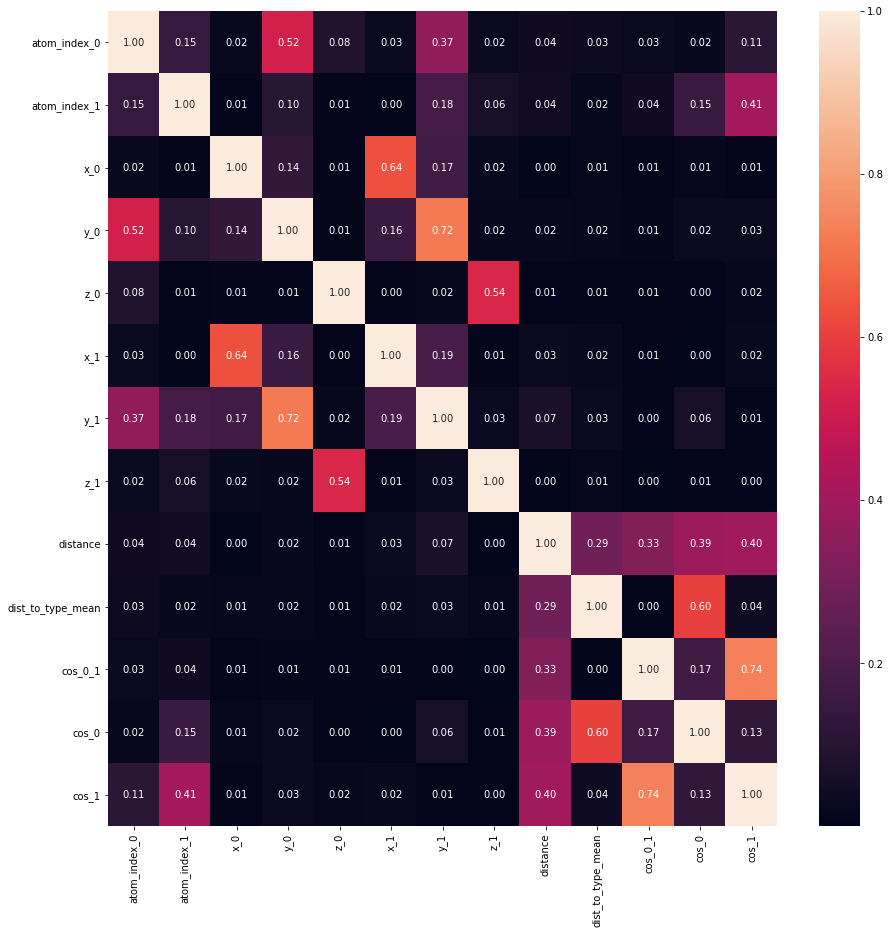

In [124]:
# Visualize the multicollinearity 
# Use heatmap from seaborn
# Set correlation score absolute value and round up to 2 digit
heatmap_df = train_df2.drop(columns=['id', 'molecule_name', 'scalar_coupling_constant','type'])
plt.figure(figsize = (15,15))
sns.heatmap(heatmap_df.corr().abs(), annot = True, fmt='.2f')

All of the multicollinearity score is below 0.8 which are acceptable scores.

#### Creating subsets

Before we enter train test split, we will make a subset of train_df2 based on the bond type.

According to the bar plot in 'Type of Bond' section, we know that there are 8 types of bond:

- {'1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'}

In [193]:
# Double check the types of bonds in the dataset
train_df2['type'].value_counts()

3JHC    1511207
2JHC    1140867
1JHC     709133
3JHH     590529
2JHH     377988
3JHN     166613
2JHN     119059
1JHN      43680
Name: type, dtype: int64

In [194]:
def subset(btype):
    '''
    This function creates and returns subset of the train_df2. 
    It will locate the rows with certain bond type and generate subset.
    
    input: 
    btype: type of bond in dataframe
    Options for btype: {'1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'}
    
    output: 
    subset in form of dataframe
    '''
    df = train_df2.loc[train_df2['type'] == btype]
    
    return df

In [243]:
# create subset for each bond type
c1_df = subset('1JHC')
n1_df = subset('1JHN')
c2_df = subset('2JHC')
h2_df = subset('2JHH')
n2_df = subset('2JHN')
c3_df = subset('3JHC')
h3_df = subset('3JHH')
n3_df = subset('3JHN')

In [244]:
# check if the subset are well splitted
print('c1')
print(c1_df['type'].value_counts())
print('')
print('c2')
print(c2_df['type'].value_counts())
print('')
print('c3')
print(c3_df['type'].value_counts())
print('')
print('n1')
print(n1_df['type'].value_counts())
print('')
print('n2')
print(n2_df['type'].value_counts())
print('')
print('n3')
print(n3_df['type'].value_counts())
print('')
print('h2')
print(h2_df['type'].value_counts())
print('')
print('h3')
print(h3_df['type'].value_counts())

c1
1JHC    709133
Name: type, dtype: int64

c2
2JHC    1140867
Name: type, dtype: int64

c3
3JHC    1511207
Name: type, dtype: int64

n1
1JHN    43680
Name: type, dtype: int64

n2
2JHN    119059
Name: type, dtype: int64

n3
3JHN    166613
Name: type, dtype: int64

h2
2JHH    377988
Name: type, dtype: int64

h3
3JHH    590529
Name: type, dtype: int64


Number of rows in each subset matches the number of rows for the each bond types in the dataset. Subset creation process was successful.

#### Normalization

As we found out in EDA process, target variable, 'scalar_coupling_constant,' has a right skewed distribution, and showed more normalized distribution after cubic root transformation. Therefore, we will apply cubic root transformation on the 'scalar_coupling_constant.'

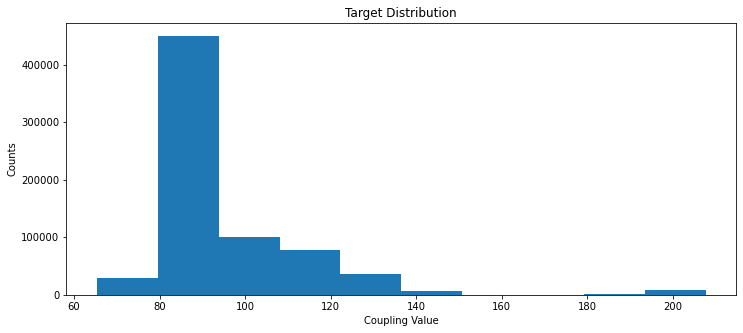

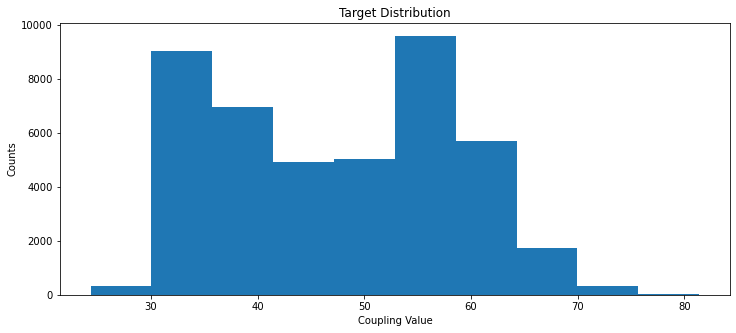

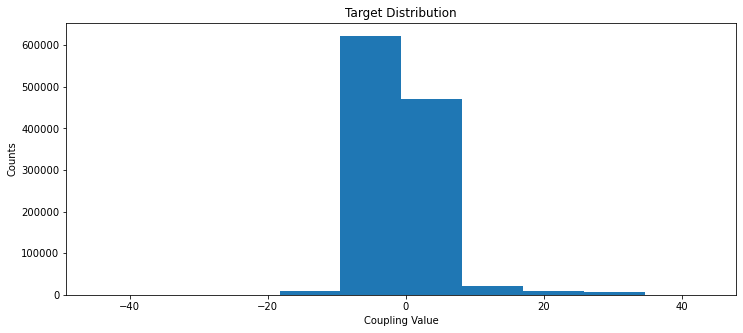

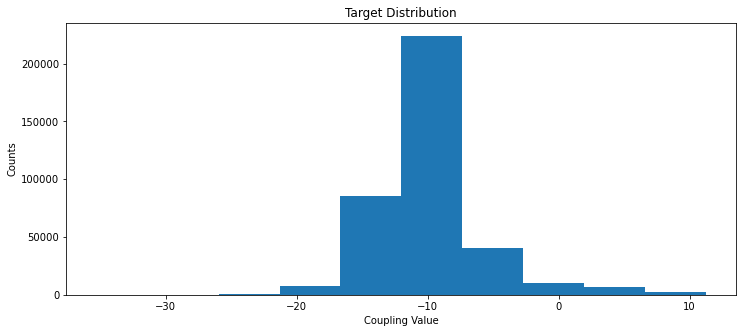

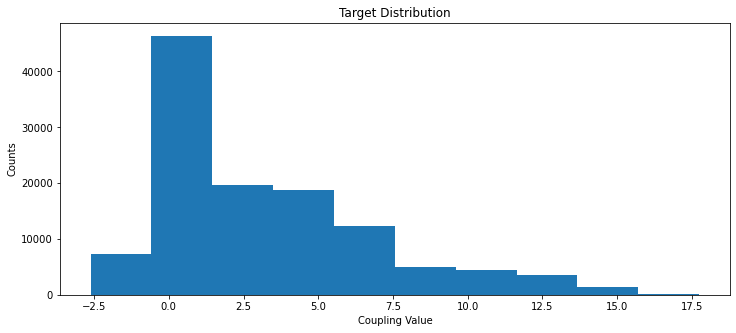

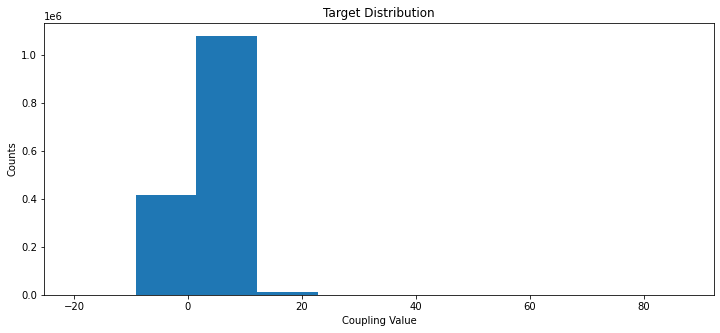

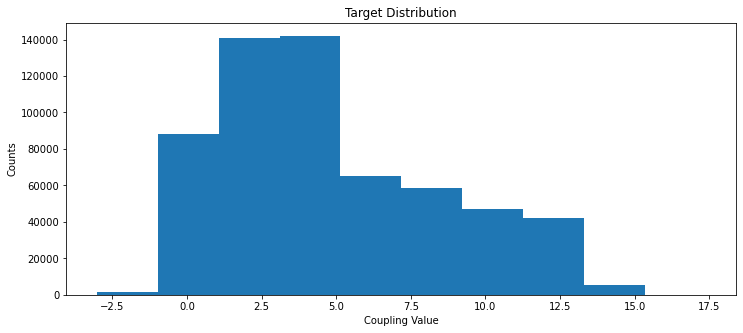

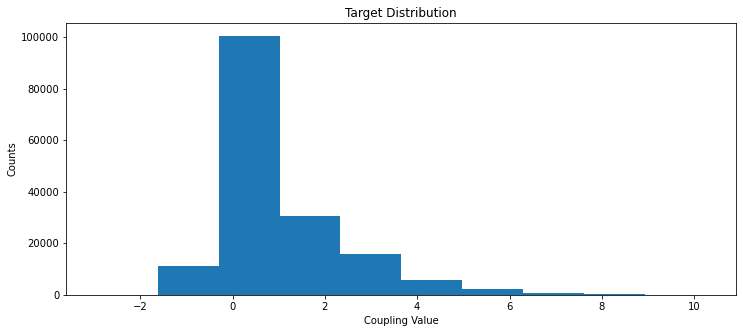

In [245]:
subset_list=[c1_df, n1_df, c2_df, h2_df, n2_df, c3_df, h3_df, n3_df]

for i in subset_list:
    fig, ax = plt.subplots(figsize=(12,5))
    ax.hist(i['scalar_coupling_constant'])
    ax.set_title('Target Distribution')
    ax.set_xlabel('Coupling Value')
    ax.set_ylabel('Counts')

The subsets that needs normalization are:
- 1JHC
- 2JHN
- 3JHC
- 3JHH
- 3JHN

Although we need to normalize the data, since the target variables include negative values, only option for normalization technique in this case is cubic root transformation

In [246]:
req_norm = [c1_df, n2_df, c3_df, h3_df, n3_df]

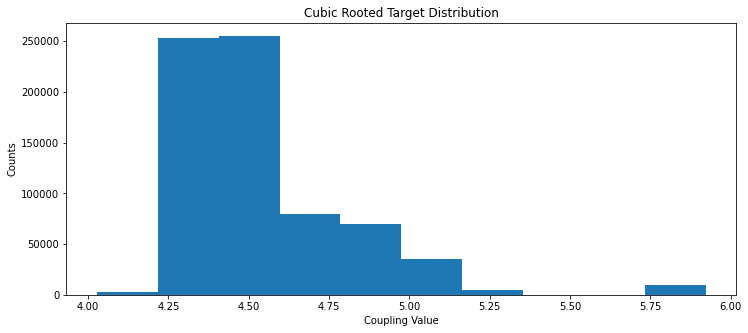

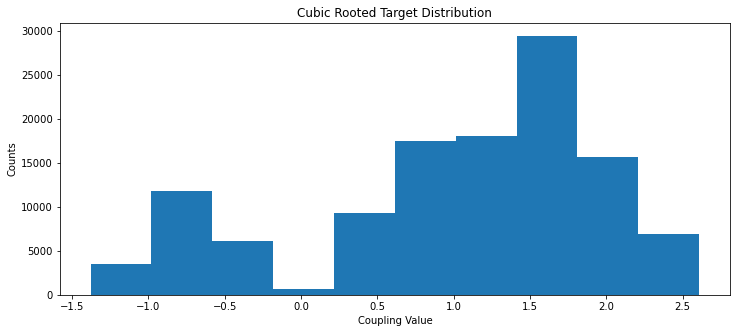

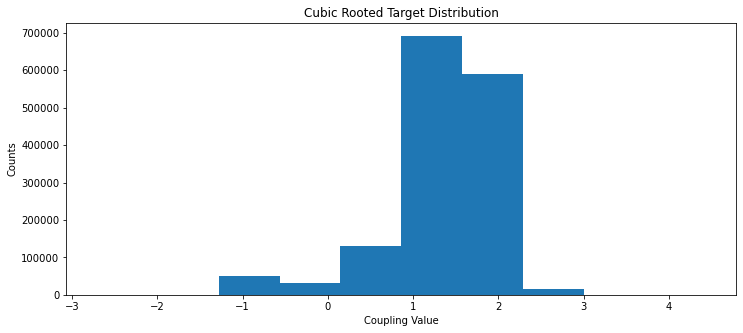

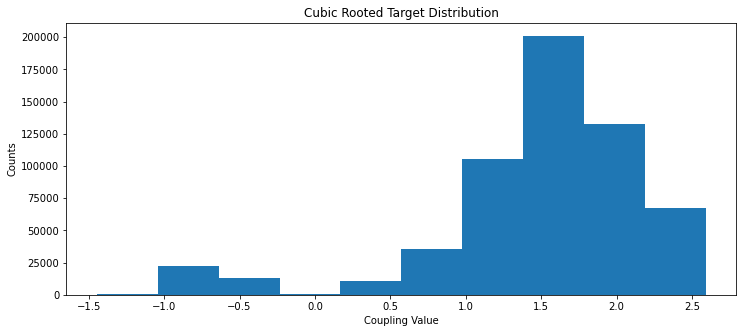

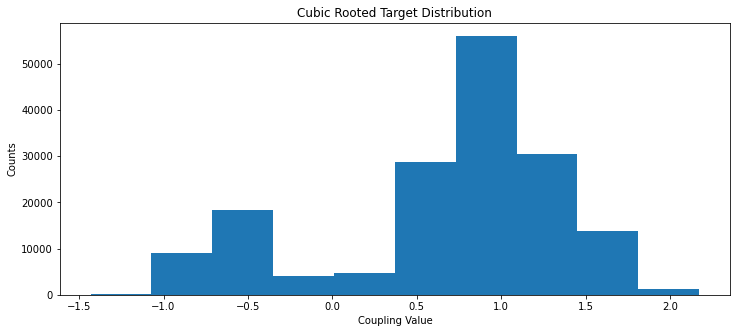

In [247]:
for i in req_norm:
    fig, ax = plt.subplots(figsize=(12,5))
    ax.hist(np.cbrt(i['scalar_coupling_constant']))
    ax.set_title('Cubic Rooted Target Distribution')
    ax.set_xlabel('Coupling Value')
    ax.set_ylabel('Counts')

Now, we will drop the old target variable 'scalar_coupling_constant' and use 'cbrt_scalar_coupling_constant' as our target variable for regression analysis.

In [249]:
for i in req_norm:
    i['cbrt_scalar_coupling_constant'] = np.cbrt(i['scalar_coupling_constant'])
    i.drop(columns = ['scalar_coupling_constant'], inplace = True)
    i.rename(columns={'cbrt_scalar_coupling_constant': 'scalar_coupling_constant'}, inplace =True)
    i.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709133 entries, 0 to 4659075
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        709133 non-null  int64  
 1   molecule_name             709133 non-null  object 
 2   atom_index_0              709133 non-null  int64  
 3   atom_index_1              709133 non-null  int64  
 4   type                      709133 non-null  object 
 5   atom_0                    709133 non-null  object 
 6   x_0                       709133 non-null  float64
 7   y_0                       709133 non-null  float64
 8   z_0                       709133 non-null  float64
 9   atom_1                    709133 non-null  object 
 10  x_1                       709133 non-null  float64
 11  y_1                       709133 non-null  float64
 12  z_1                       709133 non-null  float64
 13  distance                  709133 non-null  

#### Train Test Split

We will split the train_df2 into X and y. We will exclude columns id and molecule_name 
- X: All columns else than trarget variable(scalar_coupling_constant), id, molecule_name, and type
    - We will exclude columns id and molecule_name since those two does not contribute to the scalar coupling constant.
    - type will be dropped since all the df are now the subset with same bond type
- y: target variable (scalar_coupling_constant)

We will conduct train test split twice to create train set, validation set, and test set.The ratio for this split will be 80% for train, 10% for validation and test, which is a common ratio. We will also create function for whole process since we have to run for each subset.

In [251]:
def ttv_split(df):
    '''
    This function splits the set of dataframe into train, validation, and test set with ration of 80:10:10.
    
    Input:
    df: Pandas Dataframe
    
    Output:
    X_train
    X_test 
    X_val 
    y_train 
    y_test
    y_val
    '''
    # Create X and y from df input
    X = df.drop(columns = ['id', 'molecule_name', 'scalar_coupling_constant','type'])
    y = df[['scalar_coupling_constant']]
    
    # Split into train and test
    # ratio train 90% : test 10%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .10, random_state = 1)
    
    # Split into train and val
    # ratio train 80% : val 10% : test 10%
    # to achieve this test_size should be 1/9
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1/9, random_state =1)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [252]:
# conduct train, test, val split for each subset
c1_X_train, c1_X_test, c1_X_val, c1_y_train, c1_y_test, c1_y_val = ttv_split(c1_df)
c2_X_train, c2_X_test, c2_X_val, c2_y_train, c2_y_test, c2_y_val = ttv_split(c2_df)
c3_X_train, c3_X_test, c3_X_val, c3_y_train, c3_y_test, c3_y_val = ttv_split(c3_df)
n1_X_train, n1_X_test, n1_X_val, n1_y_train, n1_y_test, n1_y_val = ttv_split(n1_df)
n2_X_train, n2_X_test, n2_X_val, n2_y_train, n2_y_test, n2_y_val = ttv_split(n2_df)
n3_X_train, n3_X_test, n3_X_val, n3_y_train, n3_y_test, n3_y_val = ttv_split(n3_df)
h2_X_train, h2_X_test, h2_X_val, h2_y_train, h2_y_test, h2_y_val = ttv_split(h2_df)
h3_X_train, h3_X_test, h3_X_val, h3_y_train, h3_y_test, h3_y_val = ttv_split(h3_df)

In [253]:
# check the train set for c1 subset
c1_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 567305 entries, 1794965 to 1326141
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   atom_index_0       567305 non-null  int64  
 1   atom_index_1       567305 non-null  int64  
 2   atom_0             567305 non-null  object 
 3   x_0                567305 non-null  float64
 4   y_0                567305 non-null  float64
 5   z_0                567305 non-null  float64
 6   atom_1             567305 non-null  object 
 7   x_1                567305 non-null  float64
 8   y_1                567305 non-null  float64
 9   z_1                567305 non-null  float64
 10  distance           567305 non-null  float64
 11  dist_to_type_mean  567305 non-null  float64
 12  cos_0_1            567305 non-null  float64
 13  cos_0              567305 non-null  float64
 14  cos_1              567305 non-null  float64
dtypes: float64(11), int64(2), object(2)
memory u

In [254]:
# check the validation set for c1 subset
c1_X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70914 entries, 3488947 to 3414450
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   atom_index_0       70914 non-null  int64  
 1   atom_index_1       70914 non-null  int64  
 2   atom_0             70914 non-null  object 
 3   x_0                70914 non-null  float64
 4   y_0                70914 non-null  float64
 5   z_0                70914 non-null  float64
 6   atom_1             70914 non-null  object 
 7   x_1                70914 non-null  float64
 8   y_1                70914 non-null  float64
 9   z_1                70914 non-null  float64
 10  distance           70914 non-null  float64
 11  dist_to_type_mean  70914 non-null  float64
 12  cos_0_1            70914 non-null  float64
 13  cos_0              70914 non-null  float64
 14  cos_1              70914 non-null  float64
dtypes: float64(11), int64(2), object(2)
memory usage: 8.7+ MB


In [255]:
c1_y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 567305 entries, 1794965 to 1326141
Data columns (total 1 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   scalar_coupling_constant  567305 non-null  float64
dtypes: float64(1)
memory usage: 8.7 MB


In [256]:
c1_y_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70914 entries, 3488947 to 3414450
Data columns (total 1 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   scalar_coupling_constant  70914 non-null  float64
dtypes: float64(1)
memory usage: 1.1 MB


Great! Train test validation split was successful.

#### Preprocessing Pipeline

First, we will divide up the columns into numerical and categorical. For this process, we will create a new copy of train_df2 (final dataset). Since the preprocessing is only applied for the the X set, we will exclude the following columns so the we can preprocess the columns in X sets only:
- scalar coupling constant (target variable)
- id
- molecule name
- type

In [257]:
# Create a train_df3
# exclude scalar_coupling_constant, id, molecule_name, and type
train_df3 = train_df2.drop(columns=['scalar_coupling_constant', 'id', 'molecule_name', 'type'])

In [258]:
# check the dataframe
train_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4659076 entries, 0 to 4659075
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   atom_index_0       int64  
 1   atom_index_1       int64  
 2   atom_0             object 
 3   x_0                float64
 4   y_0                float64
 5   z_0                float64
 6   atom_1             object 
 7   x_1                float64
 8   y_1                float64
 9   z_1                float64
 10  distance           float64
 11  dist_to_type_mean  float64
 12  cos_0_1            float64
 13  cos_0              float64
 14  cos_1              float64
dtypes: float64(11), int64(2), object(2)
memory usage: 568.7+ MB


In [259]:
# instantiate lists of columns
num_cols = []
cat_cols = []

# num = any columns with numerical value
# cat = everything else
for c in train_df3.columns:
    if train_df3[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    else:
        cat_cols.append(c)

In [260]:
# check numerical columns
num_cols

['atom_index_0',
 'atom_index_1',
 'x_0',
 'y_0',
 'z_0',
 'x_1',
 'y_1',
 'z_1',
 'distance',
 'dist_to_type_mean',
 'cos_0_1',
 'cos_0',
 'cos_1']

In [261]:
# check categorical columns
cat_cols

['atom_0', 'atom_1']

For the pipeline, we will first define the transformers for each column type.
- MinMaxScaler: Numerical columns
- OneHotEncoder: Categorical columns

In [262]:
# Define transformers for each columns using pipeline
num_transformer = Pipeline(steps=[('minmaxscaler', MinMaxScaler())])
cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder())])

Then, combine transformers into preprocessor using ColumnTransformer.

In [263]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols),
    ])

Finally, we will fit the preprocessor to one of X_train.

In [264]:
# Fit preprocessor to training set
preprocessor.fit(c1_X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['atom_index_0', 'atom_index_1', 'x_0', 'y_0',
                                  'z_0', 'x_1', 'y_1', 'z_1', 'distance',
                                  'dist_to_type_mean', 'cos_0_1', 'cos_0',
                                  'cos_1']),
                                ('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 ['atom_0', 'atom_1'])])

## 4. Modeling

There are multiple options for solving the regression problem. 
- Linear Regression
- Random Forest 
- XGBoost
- Light Gradient Boost (LGBM)
- CatBoost
- Keras Neural Networks

After the modeling is done, models will be evaluated. Models will be selected for each subset based on the performance on the validation set.
- Highest R2 Score
- Lowest RMSE and MAE

Since the multiple modeling will be done for each type of models, we will create function for fitting and evaluating the model to speed up the process.

In [265]:
def fit_and_eval(regressor, X_train, y_train, X_val, y_val):
    '''
    This function:
    1. Creates the model using pipeline with the regressor input
    2. Fits the model
    3. Predict the values based on fitted model
    4. Report the results for evaluation (R2 score, Root Mean Squared Error (RMSE), Mean Absolute Error(MAE))
    5. Plot the scatter plot of prediction on validation set with best fit line 
    
    Input:
    regressor: machine learning model ( ex) LinearRegression(), RandomForestRegressor(), ... )
    X_train: train dataset for features (X)
    y_train: train dataset for target variable (y)
    X_val: validation dataset for features (X)
    y_val: validation dataset for target variable (y)    
    
    Output:
    Result Report and Scatter Plot
    '''
    # Create model with pipeline
    model = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', regressor)
                        ])
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on train and validation set
    tr_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    # Report Results (R2, RMSE, MAE)
    print('Result Report')
    print('')
    print(f'Train R2 Score: {r2_score(y_train, tr_pred)}')
    print(f'Validation R2 Score: {r2_score(y_val, val_pred)}')
    print('')
    print(f'Train RMSE: {mean_squared_error(y_train, tr_pred, squared = False)}')
    print(f'Validation RMSE: {mean_squared_error(y_val, val_pred, squared = False)}')
    print('')
    print(f'Train MAE: {mean_absolute_error(y_train, tr_pred)}')
    print(f'Validation MAE: {mean_absolute_error(y_val, val_pred)}')
    
    # Plot the validation prediction and best fit line
    plt.scatter(y_val,val_pred)
    plt.plot(y_val, y_val, c="Red")
    plt.xlabel('true value')
    plt.ylabel('prediction')
    
    return model

### 4.1 First Simple Model

Out of the lists of model, most simple model is Linear Regression. To understand our baseline, we will start off with the Linear Regression Model.

#### 4.1.1 1JHC

Result Report

Train R2 Score: 0.5400859538012255
Validation R2 Score: 0.539773586495508

Train RMSE: 0.1761885259638295
Validation RMSE: 0.1776330549118023

Train MAE: 0.12943938178977915
Validation MAE: 0.13010215616267687


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['atom_index_0',
                                                   'atom_index_1', 'x_0', 'y_0',
                                                   'z_0', 'x_1', 'y_1', 'z_1',
                                                   'distance',
                                                   'dist_to_type_mean',
                                                   'cos_0_1', 'cos_0',
                                                   'cos_1']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                        

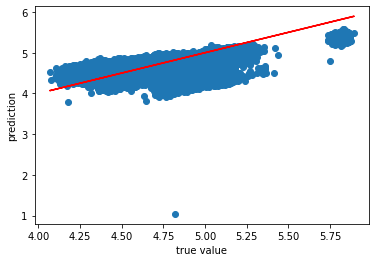

In [266]:
fit_and_eval(LinearRegression(), c1_X_train, c1_y_train, c1_X_val, c1_y_val)

#### 4.1.2 1JHN

Result Report

Train R2 Score: 0.7811479534732124
Validation R2 Score: 0.772833943755245

Train RMSE: 5.094486580093414
Validation RMSE: 5.238805865715289

Train MAE: 3.410989473425338
Validation MAE: 3.556291310382326


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['atom_index_0',
                                                   'atom_index_1', 'x_0', 'y_0',
                                                   'z_0', 'x_1', 'y_1', 'z_1',
                                                   'distance',
                                                   'dist_to_type_mean',
                                                   'cos_0_1', 'cos_0',
                                                   'cos_1']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                        

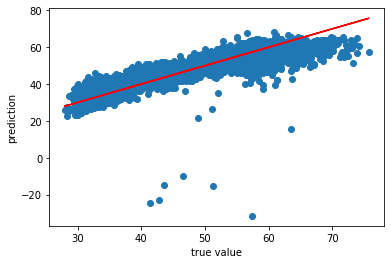

In [267]:
fit_and_eval(LinearRegression(), n1_X_train, n1_y_train, n1_X_val, n1_y_val)

#### 4.1.3 2JHC

Result Report

Train R2 Score: 0.2065037622757957
Validation R2 Score: 0.20272278712017522

Train RMSE: 4.030795664343723
Validation RMSE: 4.048129941444187

Train MAE: 2.4426799134248456
Validation MAE: 2.4401949148381346


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['atom_index_0',
                                                   'atom_index_1', 'x_0', 'y_0',
                                                   'z_0', 'x_1', 'y_1', 'z_1',
                                                   'distance',
                                                   'dist_to_type_mean',
                                                   'cos_0_1', 'cos_0',
                                                   'cos_1']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                        

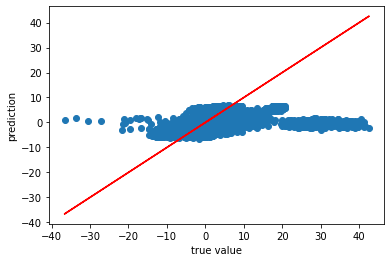

In [268]:
fit_and_eval(LinearRegression(), c2_X_train, c2_y_train, c2_X_val, c2_y_val)

#### 4.1.4 2JHH

Result Report

Train R2 Score: 0.7386225911524227
Validation R2 Score: 0.7453552583183037

Train RMSE: 2.032009870653874
Validation RMSE: 2.034344447879262

Train MAE: 1.4566952424254063
Validation MAE: 1.465242803830833


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['atom_index_0',
                                                   'atom_index_1', 'x_0', 'y_0',
                                                   'z_0', 'x_1', 'y_1', 'z_1',
                                                   'distance',
                                                   'dist_to_type_mean',
                                                   'cos_0_1', 'cos_0',
                                                   'cos_1']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                        

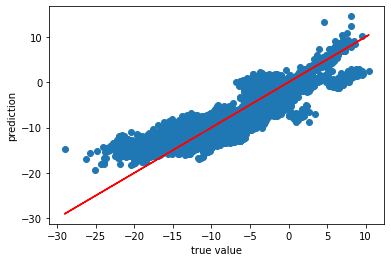

In [269]:
fit_and_eval(LinearRegression(), h2_X_train, h2_y_train, h2_X_val, h2_y_val)

#### 4.1.5 2JHN

Result Report

Train R2 Score: 0.12682904418848318
Validation R2 Score: 0.13710391872126593

Train RMSE: 0.9022780480794584
Validation RMSE: 0.8956627041499823

Train MAE: 0.7200294720093227
Validation MAE: 0.7177916945693169


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['atom_index_0',
                                                   'atom_index_1', 'x_0', 'y_0',
                                                   'z_0', 'x_1', 'y_1', 'z_1',
                                                   'distance',
                                                   'dist_to_type_mean',
                                                   'cos_0_1', 'cos_0',
                                                   'cos_1']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                        

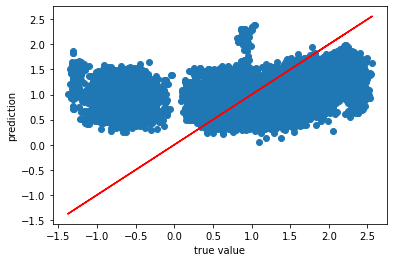

In [270]:
fit_and_eval(LinearRegression(), n2_X_train, n2_y_train, n2_X_val, n2_y_val)

#### 4.1.6 3JHC

Result Report

Train R2 Score: 0.06613920938453666
Validation R2 Score: 0.06494330413068017

Train RMSE: 0.6158600015214768
Validation RMSE: 0.6179664907178174

Train MAE: 0.43219357976368766
Validation MAE: 0.43363294572307953


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['atom_index_0',
                                                   'atom_index_1', 'x_0', 'y_0',
                                                   'z_0', 'x_1', 'y_1', 'z_1',
                                                   'distance',
                                                   'dist_to_type_mean',
                                                   'cos_0_1', 'cos_0',
                                                   'cos_1']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                        

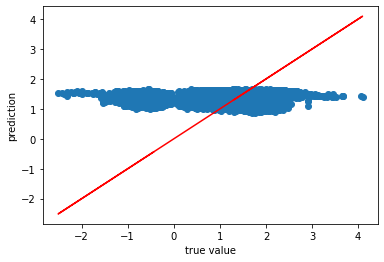

In [271]:
fit_and_eval(LinearRegression(), c3_X_train, c3_y_train, c3_X_val, c3_y_val)

#### 4.1.7 3JHH

Result Report

Train R2 Score: 0.26831230760178226
Validation R2 Score: 0.27065266576016234

Train RMSE: 0.606523890956363
Validation RMSE: 0.6021013260802092

Train MAE: 0.4323956394014561
Validation MAE: 0.4296639064312755


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['atom_index_0',
                                                   'atom_index_1', 'x_0', 'y_0',
                                                   'z_0', 'x_1', 'y_1', 'z_1',
                                                   'distance',
                                                   'dist_to_type_mean',
                                                   'cos_0_1', 'cos_0',
                                                   'cos_1']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                        

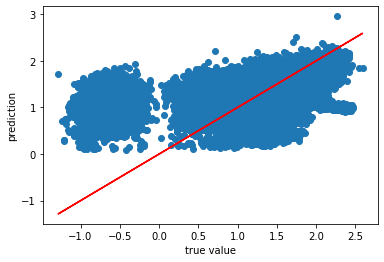

In [272]:
fit_and_eval(LinearRegression(), h3_X_train, h3_y_train, h3_X_val, h3_y_val)

#### 4.1.8 3JHN

Result Report

Train R2 Score: 0.062466682439557775
Validation R2 Score: 0.06308423656481466

Train RMSE: 0.6766004807795243
Validation RMSE: 0.6699639096234922

Train MAE: 0.5308477391161471
Validation MAE: 0.5252463971326927


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['atom_index_0',
                                                   'atom_index_1', 'x_0', 'y_0',
                                                   'z_0', 'x_1', 'y_1', 'z_1',
                                                   'distance',
                                                   'dist_to_type_mean',
                                                   'cos_0_1', 'cos_0',
                                                   'cos_1']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                        

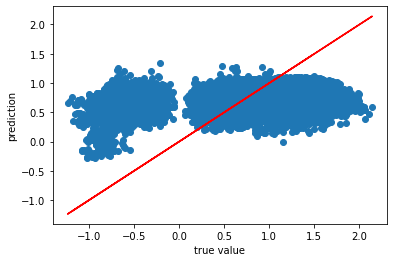

In [273]:
fit_and_eval(LinearRegression(), n3_X_train, n3_y_train, n3_X_val, n3_y_val)

#### 4.1.9 Overall Evaluation

Evaluation on the validation sets:
- R2 score: mostly very low (range)
- RMSE: varies but mostly very high 
- MAE: varies between 1 to 9

Our linear regression models results proves that the most of the bond type cannot be explained with simple linear regression. However, there are three notable results for following bond types:

- 1JHC
- 1JHN
- 2JHH

The bond type listed above has reasonable R_squared value (above 0.5). Among the three, 2JHH showed the best performance (R2 score 0.745 and errors both around 2 or below). However, all three of them are below 0.8 which proves that we need to try out different regression models.

### 4.2 Random Forest Regressor

Second model is Random Forest Regressor.

#### 4.2.1 1JHC

Result Report

Train R2 Score: 0.9863778144303937
Validation R2 Score: 0.9046855706706856

Train RMSE: 0.030322337792726393
Validation RMSE: 0.0808383314184135

Train MAE: 0.020107260246587606
Validation MAE: 0.05414712992249562


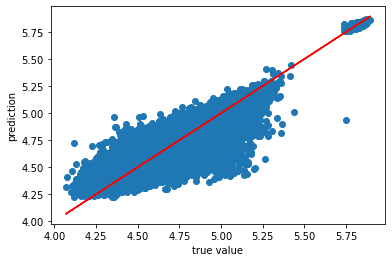

In [56]:
fit_and_eval(RandomForestRegressor(), c1_X_train, c1_y_train, c1_X_val, c1_y_val)

#### 4.2.2 1JHN

Result Report

Train R2 Score: 0.9923931237237383
Validation R2 Score: 0.9473746379621897

Train RMSE: 0.024479283617729105
Validation RMSE: 0.06498414400744733

Train MAE: 0.01607969287198849
Validation MAE: 0.04350598101938281


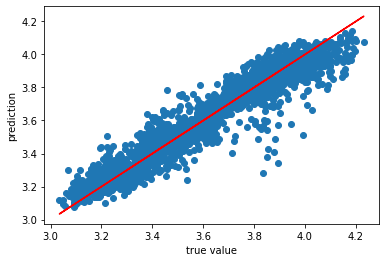

In [57]:
fit_and_eval(RandomForestRegressor(), n1_X_train, n1_y_train, n1_X_val, n1_y_val)

#### 4.2.3 2JHC

Result Report

Train R2 Score: 0.9651095010972819
Validation R2 Score: 0.7510273578085813

Train RMSE: 0.2395837198082724
Validation RMSE: 0.6398994440326958

Train MAE: 0.15418305953942932
Validation MAE: 0.4167823388033996


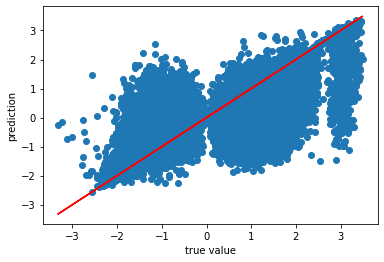

In [58]:
fit_and_eval(RandomForestRegressor(), c2_X_train, c2_y_train, c2_X_val, c2_y_val)

#### 4.2.4 2JHH 

Result Report

Train R2 Score: 0.9914145465393867
Validation R2 Score: 0.9385467052517623

Train RMSE: 0.06419746906109704
Validation RMSE: 0.17464714964413625

Train MAE: 0.02458911223257715
Validation MAE: 0.0669662853032396


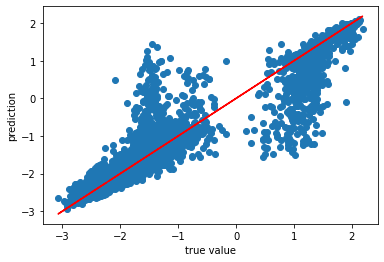

In [59]:
fit_and_eval(RandomForestRegressor(), h2_X_train, h2_y_train, h2_X_val, h2_y_val)

#### 4.2.5 2JHN

Result Report

Train R2 Score: 0.9829944284537306
Validation R2 Score: 0.8777713259162386

Train RMSE: 0.12591757961484934
Validation RMSE: 0.3370945975185742

Train MAE: 0.06612812819197364
Validation MAE: 0.17815679251967917


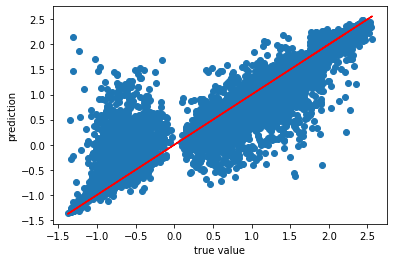

In [60]:
fit_and_eval(RandomForestRegressor(), n2_X_train, n2_y_train, n2_X_val, n2_y_val)

#### 4.2.6 3JHC

Result Report

Train R2 Score: 0.9703557286695481
Validation R2 Score: 0.7883585485817667

Train RMSE: 0.10972644728695201
Validation RMSE: 0.2939993156049113

Train MAE: 0.06239109382420795
Validation MAE: 0.1675331418212101


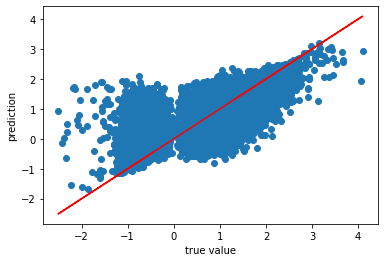

In [61]:
fit_and_eval(RandomForestRegressor(), c3_X_train, c3_y_train, c3_X_val, c3_y_val)

#### 4.2.7 3JHH 

Result Report

Train R2 Score: 0.9926301758609001
Validation R2 Score: 0.948421317280832

Train RMSE: 0.06087144337401879
Validation RMSE: 0.16011702303843325

Train MAE: 0.030854355686690434
Validation MAE: 0.08236770998273693


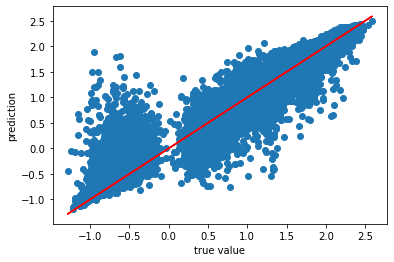

In [62]:
fit_and_eval(RandomForestRegressor(), h3_X_train, h3_y_train, h3_X_val, h3_y_val)

#### 4.2.8 3JHN

Result Report

Train R2 Score: 0.9751154639785259
Validation R2 Score: 0.8216958826227359

Train RMSE: 0.11023099324238222
Validation RMSE: 0.2922683725519459

Train MAE: 0.06484646907042131
Validation MAE: 0.1725125994661966


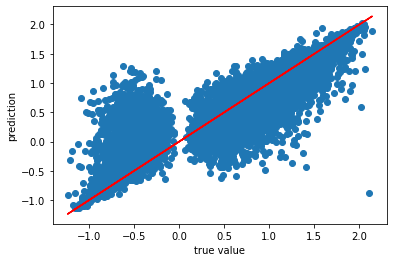

In [63]:
fit_and_eval(RandomForestRegressor(), n3_X_train, n3_y_train, n3_X_val, n3_y_val)

#### 4.2.9 Overall Evaluation
We can see there is an overfitting for every bond types with no parameters added to the Random Forest Regressor. However, the results are more promising than the simple linear regression. With hyper paramter tuning, there is a possibility of enhance the performance on validation set while reducing the error scores.

### 4.3 XGB Regressor


Third model is X Gradient Boost (XGB) regressor.

#### 4.3.1 1JHC

Result Report

Train R2 Score: 0.878498362837633
Validation R2 Score: 0.8743763598637871

Train RMSE: 0.09055873562917371
Validation RMSE: 0.09280549713369582

Train MAE: 0.06391078800213688
Validation MAE: 0.06539428890420937


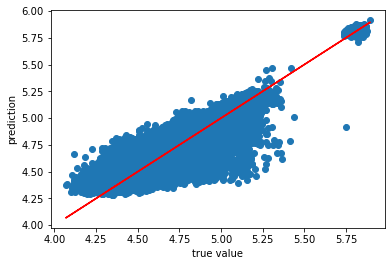

In [64]:
fit_and_eval(XGBRegressor(), c1_X_train, c1_y_train, c1_X_val, c1_y_val)

#### 4.3.2 1JHN

Result Report

Train R2 Score: 0.9611418210423667
Validation R2 Score: 0.9409047609193428

Train RMSE: 0.05532695257559471
Validation RMSE: 0.068863025787273

Train MAE: 0.03999373496775552
Validation MAE: 0.04934036145359434


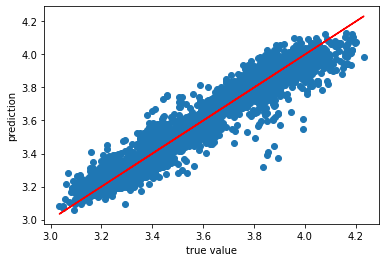

In [65]:
fit_and_eval(XGBRegressor(), n1_X_train, n1_y_train, n1_X_val, n1_y_val)

#### 4.3.3 2JHC

Result Report

Train R2 Score: 0.6039426216249371
Validation R2 Score: 0.5911828446851153

Train RMSE: 0.8072030012863067
Validation RMSE: 0.8199747417067282

Train MAE: 0.5945324717925408
Validation MAE: 0.6051323618442073


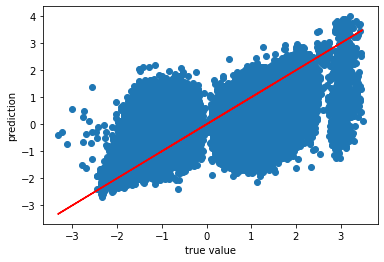

In [66]:
fit_and_eval(XGBRegressor(), c2_X_train, c2_y_train, c2_X_val, c2_y_val)

#### 4.3.4 2JHH

Result Report

Train R2 Score: 0.9527689679237278
Validation R2 Score: 0.9294357604931742

Train RMSE: 0.15057400615342623
Validation RMSE: 0.18714630149035769

Train MAE: 0.07613450833478708
Validation MAE: 0.08499064757077696


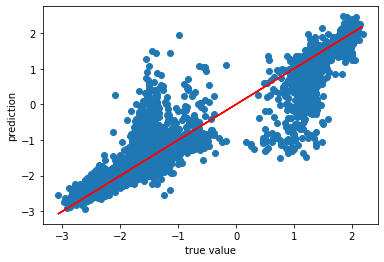

In [67]:
fit_and_eval(XGBRegressor(), h2_X_train, h2_y_train, h2_X_val, h2_y_val)

#### 4.3.5 2JHN

Result Report

Train R2 Score: 0.85496832533436
Validation R2 Score: 0.8142925038106326

Train RMSE: 0.36772417436536997
Validation RMSE: 0.41550854477673876

Train MAE: 0.24001798395301582
Validation MAE: 0.26991101375333537


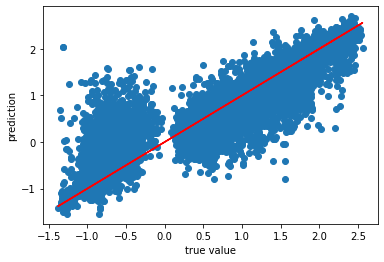

In [68]:
fit_and_eval(XGBRegressor(), n2_X_train, n2_y_train, n2_X_val, n2_y_val)

#### 4.3.6 3JHC

Result Report

Train R2 Score: 0.6288545788758799
Validation R2 Score: 0.6167799547135913

Train RMSE: 0.3882513562871698
Validation RMSE: 0.3956125522766776

Train MAE: 0.25435128674798496
Validation MAE: 0.25843527017337375


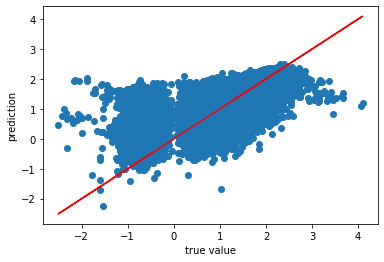

In [69]:
fit_and_eval(XGBRegressor(), c3_X_train, c3_y_train, c3_X_val, c3_y_val)

#### 4.3.7 3JHH

Result Report

Train R2 Score: 0.9196222998963544
Validation R2 Score: 0.9089903988982856

Train RMSE: 0.20102627490592556
Validation RMSE: 0.21268947005717723

Train MAE: 0.1195487430864006
Validation MAE: 0.12366974726027072


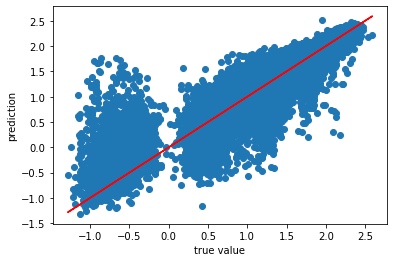

In [70]:
fit_and_eval(XGBRegressor(), h3_X_train, h3_y_train, h3_X_val, h3_y_val)

#### 4.3.8 3JHN

Result Report

Train R2 Score: 0.7490462177981974
Validation R2 Score: 0.693672845128657

Train RMSE: 0.3500546246440247
Validation RMSE: 0.38308388571169855

Train MAE: 0.24481703527301057
Validation MAE: 0.2652815333817635


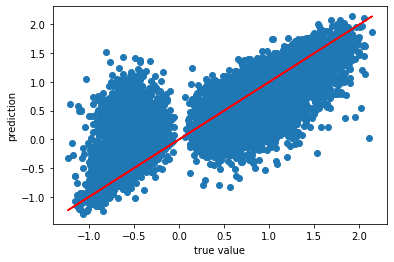

In [71]:
fit_and_eval(XGBRegressor(), n3_X_train, n3_y_train, n3_X_val, n3_y_val)

### 4.4 LGBM Regressor


Fourth model is light gradient boosting machine (LGBM) regressor.

#### 4.4.1 1JHC

Result Report

Train R2 Score: 0.8619643511836604
Validation R2 Score: 0.8619225200179035

Train RMSE: 0.09652391218415926
Validation RMSE: 0.09729699800958563

Train MAE: 0.06860582254476028
Validation MAE: 0.06906920360661879


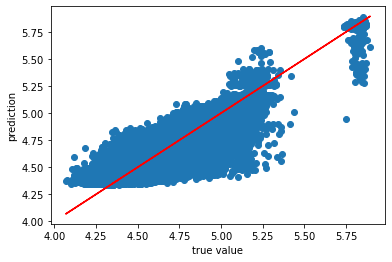

In [72]:
fit_and_eval(LGBMRegressor(), c1_X_train, c1_y_train, c1_X_val, c1_y_val)

#### 4.4.2 1JHN

Result Report

Train R2 Score: 0.9440897203844777
Validation R2 Score: 0.9346093711262634

Train RMSE: 0.0663653455331298
Validation RMSE: 0.07243819354270584

Train MAE: 0.04784040571647072
Validation MAE: 0.0519747158835483


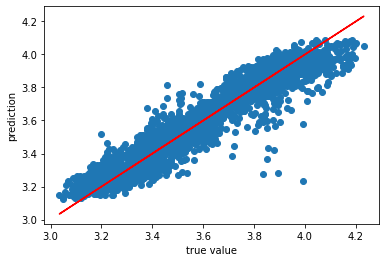

In [73]:
fit_and_eval(LGBMRegressor(), n1_X_train, n1_y_train, n1_X_val, n1_y_val)

#### 4.4.3 2JHC

Result Report

Train R2 Score: 0.5443267050832444
Validation R2 Score: 0.5406039400006655

Train RMSE: 0.8658257591942513
Validation RMSE: 0.8692196823692466

Train MAE: 0.6552282074233379
Validation MAE: 0.6584868817012258


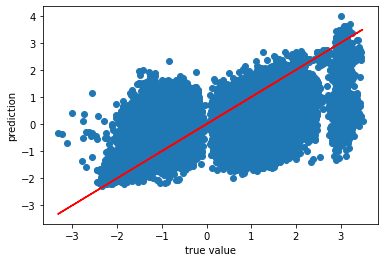

In [74]:
fit_and_eval(LGBMRegressor(), c2_X_train, c2_y_train, c2_X_val, c2_y_val)

#### 4.4.4 2JHH

Result Report

Train R2 Score: 0.9214846105180126
Validation R2 Score: 0.9130906452494258

Train RMSE: 0.19413939959294557
Validation RMSE: 0.20769315270826744

Train MAE: 0.09001286947021347
Validation MAE: 0.09390041808711362


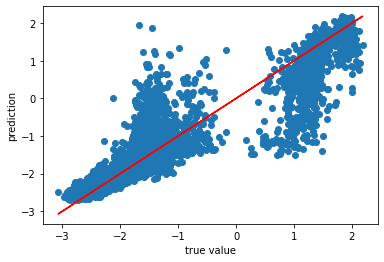

In [75]:
fit_and_eval(LGBMRegressor(), h2_X_train, h2_y_train, h2_X_val, h2_y_val)

#### 4.4.5 2JHN

Result Report

Train R2 Score: 0.7917112633806365
Validation R2 Score: 0.7769376980126713

Train RMSE: 0.44068030723189194
Validation RMSE: 0.45538459175733986

Train MAE: 0.29391456891416357
Validation MAE: 0.3026990443642192


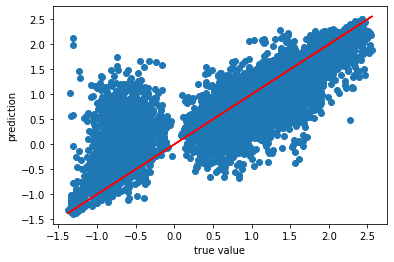

In [76]:
fit_and_eval(LGBMRegressor(), n2_X_train, n2_y_train, n2_X_val, n2_y_val)

#### 4.4.6 3JHC

Result Report

Train R2 Score: 0.5733386919360584
Validation R2 Score: 0.5692898304950029

Train RMSE: 0.41627713634166164
Validation RMSE: 0.41940974474061404

Train MAE: 0.27667985978404347
Validation MAE: 0.27798218370483185


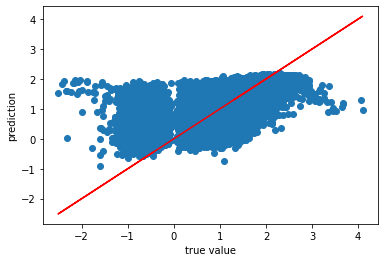

In [77]:
fit_and_eval(LGBMRegressor(), c3_X_train, c3_y_train, c3_X_val, c3_y_val)

#### 4.4.7 3JHH

Result Report

Train R2 Score: 0.8921807902582444
Validation R2 Score: 0.8900452117264039

Train RMSE: 0.23282687527593227
Validation RMSE: 0.23378113190588234

Train MAE: 0.14068696135226402
Validation MAE: 0.14072195600930498


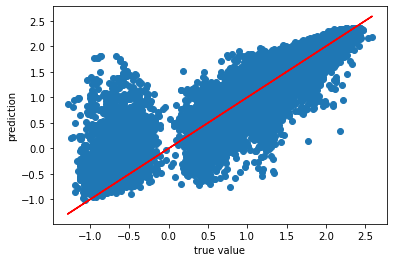

In [78]:
fit_and_eval(LGBMRegressor(), h3_X_train, h3_y_train, h3_X_val, h3_y_val)

#### 4.4.8 3JHN

Result Report

Train R2 Score: 0.6407368496689376
Validation R2 Score: 0.6233367345198702

Train RMSE: 0.4188372348944878
Validation RMSE: 0.42479340820225736

Train MAE: 0.3004522853480249
Validation MAE: 0.30373384641787304


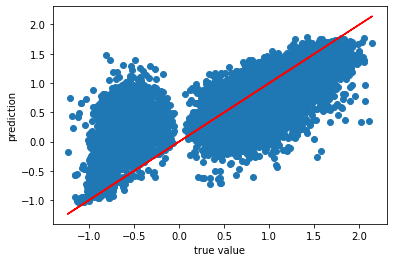

In [79]:
fit_and_eval(LGBMRegressor(), n3_X_train, n3_y_train, n3_X_val, n3_y_val)

### 5. CatBoost Regressor

Since there are some categorical columns, and some of the numerical columns, such as atom_index_0 and atom_index_1, are showing more of a categorical beahviour, we will try out the Categorical Boost (CatBoost) Regressor.

#### 4.5.1 1JHC

Learning rate set to 0.111502
0:	learn: 0.2374296	total: 194ms	remaining: 3m 13s
1:	learn: 0.2180404	total: 241ms	remaining: 2m
2:	learn: 0.2013936	total: 288ms	remaining: 1m 35s
3:	learn: 0.1869461	total: 334ms	remaining: 1m 23s
4:	learn: 0.1745391	total: 377ms	remaining: 1m 15s
5:	learn: 0.1640334	total: 435ms	remaining: 1m 12s
6:	learn: 0.1552350	total: 483ms	remaining: 1m 8s
7:	learn: 0.1477749	total: 525ms	remaining: 1m 5s
8:	learn: 0.1413986	total: 569ms	remaining: 1m 2s
9:	learn: 0.1360379	total: 624ms	remaining: 1m 1s
10:	learn: 0.1315429	total: 668ms	remaining: 1m
11:	learn: 0.1278610	total: 712ms	remaining: 58.6s
12:	learn: 0.1246868	total: 758ms	remaining: 57.5s
13:	learn: 0.1220995	total: 813ms	remaining: 57.2s
14:	learn: 0.1199374	total: 856ms	remaining: 56.2s
15:	learn: 0.1180849	total: 903ms	remaining: 55.5s
16:	learn: 0.1165687	total: 953ms	remaining: 55.1s
17:	learn: 0.1153148	total: 1s	remaining: 54.6s
18:	learn: 0.1142272	total: 1.04s	remaining: 54s
19:	learn: 0.1133

163:	learn: 0.0998799	total: 7.51s	remaining: 38.3s
164:	learn: 0.0998517	total: 7.57s	remaining: 38.3s
165:	learn: 0.0998194	total: 7.61s	remaining: 38.2s
166:	learn: 0.0997986	total: 7.65s	remaining: 38.1s
167:	learn: 0.0997759	total: 7.69s	remaining: 38.1s
168:	learn: 0.0997402	total: 7.73s	remaining: 38s
169:	learn: 0.0997092	total: 7.78s	remaining: 38s
170:	learn: 0.0996618	total: 7.82s	remaining: 37.9s
171:	learn: 0.0996354	total: 7.86s	remaining: 37.8s
172:	learn: 0.0996248	total: 7.9s	remaining: 37.8s
173:	learn: 0.0996030	total: 7.95s	remaining: 37.7s
174:	learn: 0.0995772	total: 7.99s	remaining: 37.7s
175:	learn: 0.0995413	total: 8.05s	remaining: 37.7s
176:	learn: 0.0995152	total: 8.1s	remaining: 37.7s
177:	learn: 0.0994903	total: 8.14s	remaining: 37.6s
178:	learn: 0.0994638	total: 8.18s	remaining: 37.5s
179:	learn: 0.0994326	total: 8.22s	remaining: 37.5s
180:	learn: 0.0994102	total: 8.27s	remaining: 37.4s
181:	learn: 0.0993911	total: 8.3s	remaining: 37.3s
182:	learn: 0.09936

326:	learn: 0.0965984	total: 14.6s	remaining: 30.1s
327:	learn: 0.0965898	total: 14.7s	remaining: 30.1s
328:	learn: 0.0965676	total: 14.7s	remaining: 30s
329:	learn: 0.0965501	total: 14.8s	remaining: 30s
330:	learn: 0.0965345	total: 14.8s	remaining: 29.9s
331:	learn: 0.0965206	total: 14.8s	remaining: 29.9s
332:	learn: 0.0965054	total: 14.9s	remaining: 29.8s
333:	learn: 0.0964879	total: 14.9s	remaining: 29.8s
334:	learn: 0.0964772	total: 15s	remaining: 29.7s
335:	learn: 0.0964668	total: 15s	remaining: 29.7s
336:	learn: 0.0964478	total: 15.1s	remaining: 29.6s
337:	learn: 0.0964350	total: 15.1s	remaining: 29.6s
338:	learn: 0.0964226	total: 15.2s	remaining: 29.5s
339:	learn: 0.0964100	total: 15.2s	remaining: 29.5s
340:	learn: 0.0963935	total: 15.2s	remaining: 29.5s
341:	learn: 0.0963776	total: 15.3s	remaining: 29.4s
342:	learn: 0.0963647	total: 15.3s	remaining: 29.4s
343:	learn: 0.0963457	total: 15.4s	remaining: 29.3s
344:	learn: 0.0963312	total: 15.4s	remaining: 29.3s
345:	learn: 0.096312

487:	learn: 0.0946154	total: 21.6s	remaining: 22.7s
488:	learn: 0.0946053	total: 21.6s	remaining: 22.6s
489:	learn: 0.0945964	total: 21.7s	remaining: 22.6s
490:	learn: 0.0945903	total: 21.7s	remaining: 22.5s
491:	learn: 0.0945838	total: 21.8s	remaining: 22.5s
492:	learn: 0.0945733	total: 21.8s	remaining: 22.4s
493:	learn: 0.0945639	total: 21.9s	remaining: 22.4s
494:	learn: 0.0945562	total: 21.9s	remaining: 22.4s
495:	learn: 0.0945472	total: 22s	remaining: 22.3s
496:	learn: 0.0945365	total: 22s	remaining: 22.3s
497:	learn: 0.0945208	total: 22.1s	remaining: 22.2s
498:	learn: 0.0945125	total: 22.1s	remaining: 22.2s
499:	learn: 0.0944958	total: 22.1s	remaining: 22.1s
500:	learn: 0.0944834	total: 22.2s	remaining: 22.1s
501:	learn: 0.0944742	total: 22.2s	remaining: 22s
502:	learn: 0.0944676	total: 22.3s	remaining: 22s
503:	learn: 0.0944528	total: 22.3s	remaining: 22s
504:	learn: 0.0944446	total: 22.3s	remaining: 21.9s
505:	learn: 0.0944338	total: 22.4s	remaining: 21.9s
506:	learn: 0.0944199	

646:	learn: 0.0931653	total: 28.1s	remaining: 15.3s
647:	learn: 0.0931551	total: 28.2s	remaining: 15.3s
648:	learn: 0.0931480	total: 28.2s	remaining: 15.3s
649:	learn: 0.0931430	total: 28.3s	remaining: 15.2s
650:	learn: 0.0931360	total: 28.3s	remaining: 15.2s
651:	learn: 0.0931309	total: 28.3s	remaining: 15.1s
652:	learn: 0.0931230	total: 28.4s	remaining: 15.1s
653:	learn: 0.0931119	total: 28.4s	remaining: 15s
654:	learn: 0.0930997	total: 28.5s	remaining: 15s
655:	learn: 0.0930915	total: 28.5s	remaining: 14.9s
656:	learn: 0.0930854	total: 28.5s	remaining: 14.9s
657:	learn: 0.0930777	total: 28.6s	remaining: 14.9s
658:	learn: 0.0930718	total: 28.6s	remaining: 14.8s
659:	learn: 0.0930636	total: 28.7s	remaining: 14.8s
660:	learn: 0.0930566	total: 28.7s	remaining: 14.7s
661:	learn: 0.0930494	total: 28.8s	remaining: 14.7s
662:	learn: 0.0930443	total: 28.8s	remaining: 14.6s
663:	learn: 0.0930394	total: 28.8s	remaining: 14.6s
664:	learn: 0.0930313	total: 28.9s	remaining: 14.6s
665:	learn: 0.09

807:	learn: 0.0920442	total: 34.8s	remaining: 8.27s
808:	learn: 0.0920323	total: 34.8s	remaining: 8.22s
809:	learn: 0.0920223	total: 34.9s	remaining: 8.18s
810:	learn: 0.0920081	total: 34.9s	remaining: 8.13s
811:	learn: 0.0920004	total: 34.9s	remaining: 8.09s
812:	learn: 0.0919925	total: 35s	remaining: 8.04s
813:	learn: 0.0919855	total: 35s	remaining: 8s
814:	learn: 0.0919802	total: 35.1s	remaining: 7.96s
815:	learn: 0.0919725	total: 35.1s	remaining: 7.91s
816:	learn: 0.0919611	total: 35.1s	remaining: 7.87s
817:	learn: 0.0919576	total: 35.2s	remaining: 7.83s
818:	learn: 0.0919531	total: 35.2s	remaining: 7.78s
819:	learn: 0.0919481	total: 35.2s	remaining: 7.74s
820:	learn: 0.0919447	total: 35.3s	remaining: 7.69s
821:	learn: 0.0919414	total: 35.3s	remaining: 7.65s
822:	learn: 0.0919343	total: 35.4s	remaining: 7.61s
823:	learn: 0.0919254	total: 35.4s	remaining: 7.56s
824:	learn: 0.0919211	total: 35.5s	remaining: 7.52s
825:	learn: 0.0919153	total: 35.5s	remaining: 7.48s
826:	learn: 0.09190

967:	learn: 0.0910481	total: 41.3s	remaining: 1.37s
968:	learn: 0.0910445	total: 41.4s	remaining: 1.32s
969:	learn: 0.0910396	total: 41.4s	remaining: 1.28s
970:	learn: 0.0910366	total: 41.5s	remaining: 1.24s
971:	learn: 0.0910312	total: 41.5s	remaining: 1.2s
972:	learn: 0.0910214	total: 41.5s	remaining: 1.15s
973:	learn: 0.0910151	total: 41.6s	remaining: 1.11s
974:	learn: 0.0910107	total: 41.6s	remaining: 1.07s
975:	learn: 0.0910073	total: 41.6s	remaining: 1.02s
976:	learn: 0.0910016	total: 41.7s	remaining: 981ms
977:	learn: 0.0909951	total: 41.7s	remaining: 939ms
978:	learn: 0.0909914	total: 41.8s	remaining: 896ms
979:	learn: 0.0909865	total: 41.8s	remaining: 853ms
980:	learn: 0.0909795	total: 41.8s	remaining: 810ms
981:	learn: 0.0909731	total: 41.9s	remaining: 768ms
982:	learn: 0.0909674	total: 41.9s	remaining: 725ms
983:	learn: 0.0909615	total: 42s	remaining: 682ms
984:	learn: 0.0909566	total: 42s	remaining: 640ms
985:	learn: 0.0909501	total: 42.1s	remaining: 597ms
986:	learn: 0.090

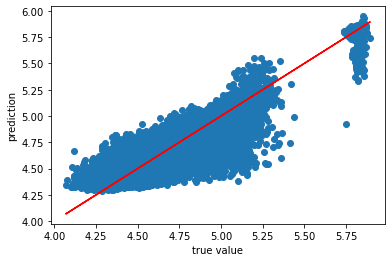

In [80]:
fit_and_eval(CatBoostRegressor(), c1_X_train, c1_y_train, c1_X_val, c1_y_val)

#### 4.5.2 1JHN

Learning rate set to 0.071785
0:	learn: 0.2633320	total: 6.81ms	remaining: 6.81s
1:	learn: 0.2477184	total: 13.5ms	remaining: 6.74s
2:	learn: 0.2333553	total: 19.4ms	remaining: 6.44s
3:	learn: 0.2200190	total: 25.3ms	remaining: 6.3s
4:	learn: 0.2077903	total: 31.1ms	remaining: 6.19s
5:	learn: 0.1964326	total: 37.1ms	remaining: 6.15s
6:	learn: 0.1860367	total: 42.9ms	remaining: 6.09s
7:	learn: 0.1764111	total: 48.9ms	remaining: 6.06s
8:	learn: 0.1677556	total: 55.3ms	remaining: 6.09s
9:	learn: 0.1598257	total: 60.8ms	remaining: 6.01s
10:	learn: 0.1526970	total: 66.5ms	remaining: 5.98s
11:	learn: 0.1461722	total: 72.8ms	remaining: 6s
12:	learn: 0.1403491	total: 78.8ms	remaining: 5.98s
13:	learn: 0.1350823	total: 85.4ms	remaining: 6.01s
14:	learn: 0.1302975	total: 91.9ms	remaining: 6.03s
15:	learn: 0.1258968	total: 98.5ms	remaining: 6.06s
16:	learn: 0.1219237	total: 104ms	remaining: 6.04s
17:	learn: 0.1182443	total: 111ms	remaining: 6.03s
18:	learn: 0.1151401	total: 117ms	remaining: 6.03s

163:	learn: 0.0767013	total: 1.03s	remaining: 5.24s
164:	learn: 0.0766575	total: 1.03s	remaining: 5.24s
165:	learn: 0.0766179	total: 1.04s	remaining: 5.23s
166:	learn: 0.0765855	total: 1.05s	remaining: 5.22s
167:	learn: 0.0765326	total: 1.05s	remaining: 5.22s
168:	learn: 0.0764889	total: 1.06s	remaining: 5.21s
169:	learn: 0.0764321	total: 1.06s	remaining: 5.2s
170:	learn: 0.0763970	total: 1.07s	remaining: 5.19s
171:	learn: 0.0763211	total: 1.08s	remaining: 5.19s
172:	learn: 0.0762752	total: 1.08s	remaining: 5.18s
173:	learn: 0.0762240	total: 1.09s	remaining: 5.17s
174:	learn: 0.0761894	total: 1.09s	remaining: 5.16s
175:	learn: 0.0761183	total: 1.1s	remaining: 5.15s
176:	learn: 0.0760569	total: 1.11s	remaining: 5.15s
177:	learn: 0.0760255	total: 1.11s	remaining: 5.14s
178:	learn: 0.0759996	total: 1.12s	remaining: 5.14s
179:	learn: 0.0759624	total: 1.13s	remaining: 5.13s
180:	learn: 0.0758671	total: 1.13s	remaining: 5.13s
181:	learn: 0.0758371	total: 1.14s	remaining: 5.12s
182:	learn: 0.

325:	learn: 0.0704303	total: 2.07s	remaining: 4.28s
326:	learn: 0.0704115	total: 2.08s	remaining: 4.28s
327:	learn: 0.0703536	total: 2.08s	remaining: 4.27s
328:	learn: 0.0703268	total: 2.09s	remaining: 4.27s
329:	learn: 0.0702969	total: 2.1s	remaining: 4.26s
330:	learn: 0.0702707	total: 2.11s	remaining: 4.26s
331:	learn: 0.0702520	total: 2.11s	remaining: 4.25s
332:	learn: 0.0702169	total: 2.12s	remaining: 4.24s
333:	learn: 0.0701905	total: 2.13s	remaining: 4.24s
334:	learn: 0.0701604	total: 2.13s	remaining: 4.23s
335:	learn: 0.0701415	total: 2.14s	remaining: 4.22s
336:	learn: 0.0701212	total: 2.14s	remaining: 4.22s
337:	learn: 0.0700803	total: 2.15s	remaining: 4.21s
338:	learn: 0.0700491	total: 2.16s	remaining: 4.21s
339:	learn: 0.0700192	total: 2.16s	remaining: 4.2s
340:	learn: 0.0699821	total: 2.17s	remaining: 4.19s
341:	learn: 0.0699508	total: 2.17s	remaining: 4.19s
342:	learn: 0.0699312	total: 2.18s	remaining: 4.18s
343:	learn: 0.0698988	total: 2.19s	remaining: 4.17s
344:	learn: 0.

508:	learn: 0.0660943	total: 3.1s	remaining: 2.99s
509:	learn: 0.0660816	total: 3.1s	remaining: 2.98s
510:	learn: 0.0660557	total: 3.11s	remaining: 2.98s
511:	learn: 0.0660325	total: 3.12s	remaining: 2.97s
512:	learn: 0.0660139	total: 3.12s	remaining: 2.96s
513:	learn: 0.0660010	total: 3.13s	remaining: 2.96s
514:	learn: 0.0659709	total: 3.13s	remaining: 2.95s
515:	learn: 0.0659531	total: 3.14s	remaining: 2.94s
516:	learn: 0.0659306	total: 3.14s	remaining: 2.94s
517:	learn: 0.0659133	total: 3.15s	remaining: 2.93s
518:	learn: 0.0659004	total: 3.15s	remaining: 2.92s
519:	learn: 0.0658858	total: 3.16s	remaining: 2.92s
520:	learn: 0.0658719	total: 3.17s	remaining: 2.91s
521:	learn: 0.0658524	total: 3.17s	remaining: 2.9s
522:	learn: 0.0658334	total: 3.18s	remaining: 2.9s
523:	learn: 0.0658171	total: 3.18s	remaining: 2.89s
524:	learn: 0.0657999	total: 3.19s	remaining: 2.88s
525:	learn: 0.0657805	total: 3.19s	remaining: 2.88s
526:	learn: 0.0657704	total: 3.2s	remaining: 2.87s
527:	learn: 0.065

692:	learn: 0.0631163	total: 4.13s	remaining: 1.83s
693:	learn: 0.0631037	total: 4.13s	remaining: 1.82s
694:	learn: 0.0630886	total: 4.14s	remaining: 1.82s
695:	learn: 0.0630794	total: 4.14s	remaining: 1.81s
696:	learn: 0.0630548	total: 4.15s	remaining: 1.8s
697:	learn: 0.0630412	total: 4.16s	remaining: 1.8s
698:	learn: 0.0630307	total: 4.16s	remaining: 1.79s
699:	learn: 0.0630135	total: 4.17s	remaining: 1.78s
700:	learn: 0.0630007	total: 4.17s	remaining: 1.78s
701:	learn: 0.0629777	total: 4.18s	remaining: 1.77s
702:	learn: 0.0629651	total: 4.18s	remaining: 1.77s
703:	learn: 0.0629438	total: 4.19s	remaining: 1.76s
704:	learn: 0.0629298	total: 4.19s	remaining: 1.75s
705:	learn: 0.0629158	total: 4.2s	remaining: 1.75s
706:	learn: 0.0629072	total: 4.2s	remaining: 1.74s
707:	learn: 0.0628969	total: 4.21s	remaining: 1.74s
708:	learn: 0.0628752	total: 4.21s	remaining: 1.73s
709:	learn: 0.0628458	total: 4.22s	remaining: 1.72s
710:	learn: 0.0628328	total: 4.22s	remaining: 1.72s
711:	learn: 0.06

876:	learn: 0.0607606	total: 5.16s	remaining: 723ms
877:	learn: 0.0607476	total: 5.16s	remaining: 717ms
878:	learn: 0.0607336	total: 5.17s	remaining: 712ms
879:	learn: 0.0607259	total: 5.17s	remaining: 706ms
880:	learn: 0.0607186	total: 5.18s	remaining: 700ms
881:	learn: 0.0607079	total: 5.19s	remaining: 694ms
882:	learn: 0.0606942	total: 5.19s	remaining: 688ms
883:	learn: 0.0606888	total: 5.2s	remaining: 682ms
884:	learn: 0.0606770	total: 5.2s	remaining: 676ms
885:	learn: 0.0606562	total: 5.21s	remaining: 670ms
886:	learn: 0.0606361	total: 5.22s	remaining: 665ms
887:	learn: 0.0606127	total: 5.22s	remaining: 659ms
888:	learn: 0.0606006	total: 5.23s	remaining: 653ms
889:	learn: 0.0605892	total: 5.23s	remaining: 647ms
890:	learn: 0.0605733	total: 5.24s	remaining: 641ms
891:	learn: 0.0605539	total: 5.25s	remaining: 635ms
892:	learn: 0.0605419	total: 5.25s	remaining: 629ms
893:	learn: 0.0605281	total: 5.26s	remaining: 623ms
894:	learn: 0.0605179	total: 5.26s	remaining: 617ms
895:	learn: 0.

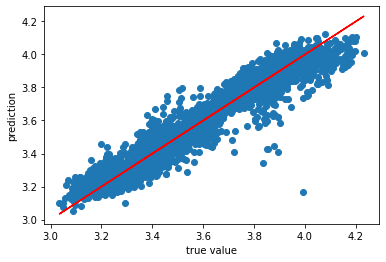

In [81]:
fit_and_eval(CatBoostRegressor(), n1_X_train, n1_y_train, n1_X_val, n1_y_val)

#### 4.5.3 2JHC

Learning rate set to 0.120202
0:	learn: 1.2343915	total: 88.7ms	remaining: 1m 28s
1:	learn: 1.1954676	total: 175ms	remaining: 1m 27s
2:	learn: 1.1629558	total: 248ms	remaining: 1m 22s
3:	learn: 1.1367322	total: 319ms	remaining: 1m 19s
4:	learn: 1.1149059	total: 386ms	remaining: 1m 16s
5:	learn: 1.0974649	total: 454ms	remaining: 1m 15s
6:	learn: 1.0814013	total: 521ms	remaining: 1m 13s
7:	learn: 1.0685262	total: 589ms	remaining: 1m 13s
8:	learn: 1.0581289	total: 654ms	remaining: 1m 12s
9:	learn: 1.0481067	total: 721ms	remaining: 1m 11s
10:	learn: 1.0398764	total: 783ms	remaining: 1m 10s
11:	learn: 1.0325371	total: 843ms	remaining: 1m 9s
12:	learn: 1.0259145	total: 913ms	remaining: 1m 9s
13:	learn: 1.0203578	total: 979ms	remaining: 1m 8s
14:	learn: 1.0154644	total: 1.04s	remaining: 1m 8s
15:	learn: 1.0115085	total: 1.1s	remaining: 1m 7s
16:	learn: 1.0075121	total: 1.16s	remaining: 1m 7s
17:	learn: 1.0036193	total: 1.22s	remaining: 1m 6s
18:	learn: 1.0000391	total: 1.29s	remaining: 1m 6s


162:	learn: 0.8863321	total: 10.7s	remaining: 54.8s
163:	learn: 0.8858998	total: 10.8s	remaining: 54.8s
164:	learn: 0.8856287	total: 10.8s	remaining: 54.8s
165:	learn: 0.8853536	total: 10.9s	remaining: 54.8s
166:	learn: 0.8849286	total: 11s	remaining: 54.7s
167:	learn: 0.8847113	total: 11s	remaining: 54.6s
168:	learn: 0.8845412	total: 11.1s	remaining: 54.5s
169:	learn: 0.8843547	total: 11.2s	remaining: 54.5s
170:	learn: 0.8840317	total: 11.2s	remaining: 54.4s
171:	learn: 0.8834172	total: 11.3s	remaining: 54.4s
172:	learn: 0.8831541	total: 11.4s	remaining: 54.3s
173:	learn: 0.8828766	total: 11.4s	remaining: 54.2s
174:	learn: 0.8826317	total: 11.5s	remaining: 54.1s
175:	learn: 0.8823655	total: 11.5s	remaining: 54s
176:	learn: 0.8821703	total: 11.6s	remaining: 54s
177:	learn: 0.8818878	total: 11.7s	remaining: 53.9s
178:	learn: 0.8817480	total: 11.7s	remaining: 53.9s
179:	learn: 0.8814743	total: 11.8s	remaining: 53.8s
180:	learn: 0.8812057	total: 11.9s	remaining: 53.8s
181:	learn: 0.880986

322:	learn: 0.8526055	total: 20.9s	remaining: 43.7s
323:	learn: 0.8524850	total: 20.9s	remaining: 43.6s
324:	learn: 0.8523057	total: 21s	remaining: 43.6s
325:	learn: 0.8521964	total: 21.1s	remaining: 43.5s
326:	learn: 0.8520570	total: 21.1s	remaining: 43.5s
327:	learn: 0.8518587	total: 21.2s	remaining: 43.4s
328:	learn: 0.8517605	total: 21.3s	remaining: 43.4s
329:	learn: 0.8516237	total: 21.3s	remaining: 43.3s
330:	learn: 0.8514686	total: 21.4s	remaining: 43.3s
331:	learn: 0.8512857	total: 21.5s	remaining: 43.2s
332:	learn: 0.8510972	total: 21.5s	remaining: 43.2s
333:	learn: 0.8509435	total: 21.6s	remaining: 43.1s
334:	learn: 0.8508209	total: 21.7s	remaining: 43s
335:	learn: 0.8507670	total: 21.7s	remaining: 42.9s
336:	learn: 0.8506087	total: 21.8s	remaining: 42.9s
337:	learn: 0.8504602	total: 21.9s	remaining: 42.8s
338:	learn: 0.8503507	total: 21.9s	remaining: 42.8s
339:	learn: 0.8502172	total: 22s	remaining: 42.7s
340:	learn: 0.8500933	total: 22.1s	remaining: 42.7s
341:	learn: 0.8500

482:	learn: 0.8334012	total: 31.1s	remaining: 33.3s
483:	learn: 0.8333307	total: 31.1s	remaining: 33.2s
484:	learn: 0.8332052	total: 31.2s	remaining: 33.1s
485:	learn: 0.8331091	total: 31.3s	remaining: 33.1s
486:	learn: 0.8330542	total: 31.3s	remaining: 33s
487:	learn: 0.8329315	total: 31.4s	remaining: 32.9s
488:	learn: 0.8328545	total: 31.4s	remaining: 32.9s
489:	learn: 0.8327888	total: 31.5s	remaining: 32.8s
490:	learn: 0.8327248	total: 31.6s	remaining: 32.7s
491:	learn: 0.8326340	total: 31.6s	remaining: 32.7s
492:	learn: 0.8325436	total: 31.7s	remaining: 32.6s
493:	learn: 0.8324257	total: 31.8s	remaining: 32.5s
494:	learn: 0.8323347	total: 31.8s	remaining: 32.5s
495:	learn: 0.8322598	total: 31.9s	remaining: 32.4s
496:	learn: 0.8322007	total: 31.9s	remaining: 32.3s
497:	learn: 0.8321173	total: 32s	remaining: 32.3s
498:	learn: 0.8320190	total: 32.1s	remaining: 32.2s
499:	learn: 0.8319507	total: 32.1s	remaining: 32.1s
500:	learn: 0.8317892	total: 32.2s	remaining: 32.1s
501:	learn: 0.83

642:	learn: 0.8203325	total: 41.3s	remaining: 22.9s
643:	learn: 0.8202492	total: 41.3s	remaining: 22.8s
644:	learn: 0.8201880	total: 41.4s	remaining: 22.8s
645:	learn: 0.8201203	total: 41.4s	remaining: 22.7s
646:	learn: 0.8200479	total: 41.5s	remaining: 22.6s
647:	learn: 0.8199752	total: 41.6s	remaining: 22.6s
648:	learn: 0.8199164	total: 41.6s	remaining: 22.5s
649:	learn: 0.8198519	total: 41.7s	remaining: 22.4s
650:	learn: 0.8197540	total: 41.7s	remaining: 22.4s
651:	learn: 0.8197056	total: 41.8s	remaining: 22.3s
652:	learn: 0.8195999	total: 41.9s	remaining: 22.2s
653:	learn: 0.8195356	total: 41.9s	remaining: 22.2s
654:	learn: 0.8194548	total: 42s	remaining: 22.1s
655:	learn: 0.8193993	total: 42s	remaining: 22s
656:	learn: 0.8192472	total: 42.1s	remaining: 22s
657:	learn: 0.8192209	total: 42.2s	remaining: 21.9s
658:	learn: 0.8191483	total: 42.2s	remaining: 21.9s
659:	learn: 0.8190415	total: 42.3s	remaining: 21.8s
660:	learn: 0.8189959	total: 42.4s	remaining: 21.7s
661:	learn: 0.818945

803:	learn: 0.8094869	total: 51.5s	remaining: 12.5s
804:	learn: 0.8094452	total: 51.5s	remaining: 12.5s
805:	learn: 0.8093882	total: 51.6s	remaining: 12.4s
806:	learn: 0.8093174	total: 51.6s	remaining: 12.4s
807:	learn: 0.8092688	total: 51.7s	remaining: 12.3s
808:	learn: 0.8092191	total: 51.8s	remaining: 12.2s
809:	learn: 0.8091715	total: 51.8s	remaining: 12.2s
810:	learn: 0.8091060	total: 51.9s	remaining: 12.1s
811:	learn: 0.8090508	total: 52s	remaining: 12s
812:	learn: 0.8090128	total: 52s	remaining: 12s
813:	learn: 0.8089560	total: 52.1s	remaining: 11.9s
814:	learn: 0.8088931	total: 52.2s	remaining: 11.8s
815:	learn: 0.8088484	total: 52.2s	remaining: 11.8s
816:	learn: 0.8087924	total: 52.3s	remaining: 11.7s
817:	learn: 0.8087570	total: 52.3s	remaining: 11.6s
818:	learn: 0.8086687	total: 52.4s	remaining: 11.6s
819:	learn: 0.8086113	total: 52.5s	remaining: 11.5s
820:	learn: 0.8085462	total: 52.5s	remaining: 11.5s
821:	learn: 0.8085069	total: 52.6s	remaining: 11.4s
822:	learn: 0.808455

963:	learn: 0.8013076	total: 1m 1s	remaining: 2.3s
964:	learn: 0.8012745	total: 1m 1s	remaining: 2.24s
965:	learn: 0.8012356	total: 1m 1s	remaining: 2.17s
966:	learn: 0.8011953	total: 1m 1s	remaining: 2.11s
967:	learn: 0.8011568	total: 1m 1s	remaining: 2.05s
968:	learn: 0.8011049	total: 1m 1s	remaining: 1.98s
969:	learn: 0.8010333	total: 1m 2s	remaining: 1.92s
970:	learn: 0.8009863	total: 1m 2s	remaining: 1.85s
971:	learn: 0.8009206	total: 1m 2s	remaining: 1.79s
972:	learn: 0.8008686	total: 1m 2s	remaining: 1.73s
973:	learn: 0.8008114	total: 1m 2s	remaining: 1.66s
974:	learn: 0.8007679	total: 1m 2s	remaining: 1.6s
975:	learn: 0.8007342	total: 1m 2s	remaining: 1.53s
976:	learn: 0.8006944	total: 1m 2s	remaining: 1.47s
977:	learn: 0.8006475	total: 1m 2s	remaining: 1.41s
978:	learn: 0.8005955	total: 1m 2s	remaining: 1.34s
979:	learn: 0.8005497	total: 1m 2s	remaining: 1.28s
980:	learn: 0.8005087	total: 1m 2s	remaining: 1.21s
981:	learn: 0.8004671	total: 1m 2s	remaining: 1.15s
982:	learn: 0.

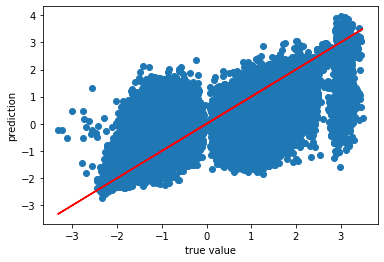

In [82]:
fit_and_eval(CatBoostRegressor(), c2_X_train, c2_y_train, c2_X_val, c2_y_val)

#### 4.5.4 2JHH

Learning rate set to 0.100951
0:	learn: 0.6415857	total: 51.1ms	remaining: 51s
1:	learn: 0.5947981	total: 73.5ms	remaining: 36.7s
2:	learn: 0.5539687	total: 96.5ms	remaining: 32.1s
3:	learn: 0.5179048	total: 119ms	remaining: 29.5s
4:	learn: 0.4862707	total: 143ms	remaining: 28.5s
5:	learn: 0.4592800	total: 167ms	remaining: 27.7s
6:	learn: 0.4349491	total: 192ms	remaining: 27.3s
7:	learn: 0.4134338	total: 218ms	remaining: 27s
8:	learn: 0.3932413	total: 242ms	remaining: 26.7s
9:	learn: 0.3767835	total: 268ms	remaining: 26.5s
10:	learn: 0.3628376	total: 293ms	remaining: 26.4s
11:	learn: 0.3511356	total: 320ms	remaining: 26.4s
12:	learn: 0.3406664	total: 342ms	remaining: 26s
13:	learn: 0.3311388	total: 367ms	remaining: 25.8s
14:	learn: 0.3224784	total: 392ms	remaining: 25.8s
15:	learn: 0.3145217	total: 416ms	remaining: 25.6s
16:	learn: 0.3087542	total: 439ms	remaining: 25.4s
17:	learn: 0.3026050	total: 462ms	remaining: 25.2s
18:	learn: 0.2981076	total: 484ms	remaining: 25s
19:	learn: 0.294

164:	learn: 0.2148895	total: 3.91s	remaining: 19.8s
165:	learn: 0.2147149	total: 3.93s	remaining: 19.7s
166:	learn: 0.2146218	total: 3.95s	remaining: 19.7s
167:	learn: 0.2144994	total: 3.98s	remaining: 19.7s
168:	learn: 0.2144165	total: 4s	remaining: 19.7s
169:	learn: 0.2142229	total: 4.02s	remaining: 19.6s
170:	learn: 0.2139820	total: 4.04s	remaining: 19.6s
171:	learn: 0.2138823	total: 4.07s	remaining: 19.6s
172:	learn: 0.2137548	total: 4.09s	remaining: 19.6s
173:	learn: 0.2135511	total: 4.12s	remaining: 19.6s
174:	learn: 0.2134603	total: 4.14s	remaining: 19.5s
175:	learn: 0.2132921	total: 4.17s	remaining: 19.5s
176:	learn: 0.2130353	total: 4.19s	remaining: 19.5s
177:	learn: 0.2129414	total: 4.21s	remaining: 19.4s
178:	learn: 0.2127504	total: 4.23s	remaining: 19.4s
179:	learn: 0.2126743	total: 4.25s	remaining: 19.4s
180:	learn: 0.2125814	total: 4.28s	remaining: 19.4s
181:	learn: 0.2125103	total: 4.3s	remaining: 19.3s
182:	learn: 0.2123934	total: 4.32s	remaining: 19.3s
183:	learn: 0.21

324:	learn: 0.1985254	total: 7.49s	remaining: 15.6s
325:	learn: 0.1984138	total: 7.51s	remaining: 15.5s
326:	learn: 0.1983620	total: 7.53s	remaining: 15.5s
327:	learn: 0.1982497	total: 7.56s	remaining: 15.5s
328:	learn: 0.1981362	total: 7.58s	remaining: 15.5s
329:	learn: 0.1980762	total: 7.61s	remaining: 15.4s
330:	learn: 0.1980165	total: 7.63s	remaining: 15.4s
331:	learn: 0.1979442	total: 7.65s	remaining: 15.4s
332:	learn: 0.1979080	total: 7.67s	remaining: 15.4s
333:	learn: 0.1978014	total: 7.7s	remaining: 15.3s
334:	learn: 0.1977460	total: 7.72s	remaining: 15.3s
335:	learn: 0.1976108	total: 7.74s	remaining: 15.3s
336:	learn: 0.1975689	total: 7.76s	remaining: 15.3s
337:	learn: 0.1974691	total: 7.79s	remaining: 15.3s
338:	learn: 0.1973838	total: 7.81s	remaining: 15.2s
339:	learn: 0.1973222	total: 7.83s	remaining: 15.2s
340:	learn: 0.1972310	total: 7.86s	remaining: 15.2s
341:	learn: 0.1971879	total: 7.88s	remaining: 15.2s
342:	learn: 0.1971379	total: 7.9s	remaining: 15.1s
343:	learn: 0.

486:	learn: 0.1888601	total: 11.3s	remaining: 11.9s
487:	learn: 0.1887893	total: 11.3s	remaining: 11.9s
488:	learn: 0.1887140	total: 11.3s	remaining: 11.9s
489:	learn: 0.1886163	total: 11.4s	remaining: 11.8s
490:	learn: 0.1885382	total: 11.4s	remaining: 11.8s
491:	learn: 0.1885064	total: 11.4s	remaining: 11.8s
492:	learn: 0.1884617	total: 11.4s	remaining: 11.8s
493:	learn: 0.1883669	total: 11.5s	remaining: 11.7s
494:	learn: 0.1882991	total: 11.5s	remaining: 11.7s
495:	learn: 0.1882319	total: 11.5s	remaining: 11.7s
496:	learn: 0.1881617	total: 11.5s	remaining: 11.7s
497:	learn: 0.1881093	total: 11.6s	remaining: 11.7s
498:	learn: 0.1880715	total: 11.6s	remaining: 11.6s
499:	learn: 0.1880229	total: 11.6s	remaining: 11.6s
500:	learn: 0.1879441	total: 11.6s	remaining: 11.6s
501:	learn: 0.1878830	total: 11.7s	remaining: 11.6s
502:	learn: 0.1878236	total: 11.7s	remaining: 11.5s
503:	learn: 0.1877604	total: 11.7s	remaining: 11.5s
504:	learn: 0.1877325	total: 11.7s	remaining: 11.5s
505:	learn: 

649:	learn: 0.1812268	total: 15.1s	remaining: 8.11s
650:	learn: 0.1811673	total: 15.1s	remaining: 8.09s
651:	learn: 0.1811407	total: 15.1s	remaining: 8.06s
652:	learn: 0.1811018	total: 15.1s	remaining: 8.04s
653:	learn: 0.1810520	total: 15.2s	remaining: 8.02s
654:	learn: 0.1809855	total: 15.2s	remaining: 8s
655:	learn: 0.1809538	total: 15.2s	remaining: 7.97s
656:	learn: 0.1809062	total: 15.2s	remaining: 7.95s
657:	learn: 0.1808684	total: 15.3s	remaining: 7.93s
658:	learn: 0.1808409	total: 15.3s	remaining: 7.91s
659:	learn: 0.1808123	total: 15.3s	remaining: 7.88s
660:	learn: 0.1807811	total: 15.3s	remaining: 7.86s
661:	learn: 0.1807316	total: 15.4s	remaining: 7.84s
662:	learn: 0.1806846	total: 15.4s	remaining: 7.82s
663:	learn: 0.1806726	total: 15.4s	remaining: 7.8s
664:	learn: 0.1806453	total: 15.4s	remaining: 7.78s
665:	learn: 0.1806137	total: 15.5s	remaining: 7.75s
666:	learn: 0.1805800	total: 15.5s	remaining: 7.73s
667:	learn: 0.1805289	total: 15.5s	remaining: 7.71s
668:	learn: 0.18

814:	learn: 0.1753852	total: 19s	remaining: 4.32s
815:	learn: 0.1753738	total: 19.1s	remaining: 4.3s
816:	learn: 0.1753435	total: 19.1s	remaining: 4.27s
817:	learn: 0.1753044	total: 19.1s	remaining: 4.25s
818:	learn: 0.1752884	total: 19.1s	remaining: 4.23s
819:	learn: 0.1752674	total: 19.2s	remaining: 4.2s
820:	learn: 0.1752333	total: 19.2s	remaining: 4.18s
821:	learn: 0.1752156	total: 19.2s	remaining: 4.16s
822:	learn: 0.1752000	total: 19.2s	remaining: 4.13s
823:	learn: 0.1751538	total: 19.2s	remaining: 4.11s
824:	learn: 0.1751129	total: 19.3s	remaining: 4.09s
825:	learn: 0.1750825	total: 19.3s	remaining: 4.06s
826:	learn: 0.1750434	total: 19.3s	remaining: 4.04s
827:	learn: 0.1750133	total: 19.3s	remaining: 4.02s
828:	learn: 0.1749904	total: 19.4s	remaining: 3.99s
829:	learn: 0.1749584	total: 19.4s	remaining: 3.97s
830:	learn: 0.1749392	total: 19.4s	remaining: 3.95s
831:	learn: 0.1748874	total: 19.4s	remaining: 3.92s
832:	learn: 0.1748442	total: 19.5s	remaining: 3.9s
833:	learn: 0.174

975:	learn: 0.1705931	total: 22.8s	remaining: 561ms
976:	learn: 0.1705779	total: 22.9s	remaining: 538ms
977:	learn: 0.1705208	total: 22.9s	remaining: 515ms
978:	learn: 0.1705004	total: 22.9s	remaining: 492ms
979:	learn: 0.1704836	total: 23s	remaining: 468ms
980:	learn: 0.1704655	total: 23s	remaining: 445ms
981:	learn: 0.1704348	total: 23s	remaining: 422ms
982:	learn: 0.1704093	total: 23s	remaining: 398ms
983:	learn: 0.1703970	total: 23.1s	remaining: 375ms
984:	learn: 0.1703854	total: 23.1s	remaining: 351ms
985:	learn: 0.1703686	total: 23.1s	remaining: 328ms
986:	learn: 0.1703452	total: 23.1s	remaining: 305ms
987:	learn: 0.1703188	total: 23.1s	remaining: 281ms
988:	learn: 0.1703008	total: 23.2s	remaining: 258ms
989:	learn: 0.1702702	total: 23.2s	remaining: 234ms
990:	learn: 0.1702330	total: 23.2s	remaining: 211ms
991:	learn: 0.1702104	total: 23.2s	remaining: 187ms
992:	learn: 0.1701667	total: 23.3s	remaining: 164ms
993:	learn: 0.1701441	total: 23.3s	remaining: 141ms
994:	learn: 0.170111

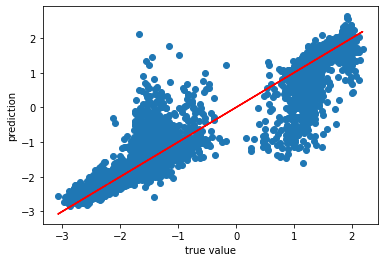

In [83]:
fit_and_eval(CatBoostRegressor(), h2_X_train, h2_y_train, h2_X_val, h2_y_val)

#### 4.5.5 2JHN

Learning rate set to 0.084108
0:	learn: 0.9332545	total: 26.7ms	remaining: 26.7s
1:	learn: 0.9047831	total: 37.7ms	remaining: 18.8s
2:	learn: 0.8783840	total: 48.5ms	remaining: 16.1s
3:	learn: 0.8539051	total: 59.4ms	remaining: 14.8s
4:	learn: 0.8337450	total: 70.8ms	remaining: 14.1s
5:	learn: 0.8154450	total: 82.6ms	remaining: 13.7s
6:	learn: 0.7995839	total: 93.5ms	remaining: 13.3s
7:	learn: 0.7830041	total: 104ms	remaining: 12.9s
8:	learn: 0.7684884	total: 114ms	remaining: 12.6s
9:	learn: 0.7536478	total: 125ms	remaining: 12.4s
10:	learn: 0.7400973	total: 136ms	remaining: 12.2s
11:	learn: 0.7292834	total: 147ms	remaining: 12.1s
12:	learn: 0.7206895	total: 158ms	remaining: 12s
13:	learn: 0.7131849	total: 185ms	remaining: 13s
14:	learn: 0.7044142	total: 196ms	remaining: 12.9s
15:	learn: 0.6982409	total: 206ms	remaining: 12.7s
16:	learn: 0.6914334	total: 217ms	remaining: 12.5s
17:	learn: 0.6838990	total: 228ms	remaining: 12.4s
18:	learn: 0.6769574	total: 239ms	remaining: 12.4s
19:	lear

165:	learn: 0.4987246	total: 1.75s	remaining: 8.79s
166:	learn: 0.4982898	total: 1.76s	remaining: 8.78s
167:	learn: 0.4978262	total: 1.77s	remaining: 8.76s
168:	learn: 0.4975149	total: 1.78s	remaining: 8.75s
169:	learn: 0.4971809	total: 1.79s	remaining: 8.73s
170:	learn: 0.4968387	total: 1.8s	remaining: 8.72s
171:	learn: 0.4964032	total: 1.81s	remaining: 8.7s
172:	learn: 0.4960437	total: 1.82s	remaining: 8.69s
173:	learn: 0.4956296	total: 1.83s	remaining: 8.68s
174:	learn: 0.4951969	total: 1.84s	remaining: 8.66s
175:	learn: 0.4949459	total: 1.85s	remaining: 8.65s
176:	learn: 0.4946374	total: 1.86s	remaining: 8.63s
177:	learn: 0.4943449	total: 1.87s	remaining: 8.62s
178:	learn: 0.4940031	total: 1.88s	remaining: 8.61s
179:	learn: 0.4936050	total: 1.89s	remaining: 8.59s
180:	learn: 0.4932739	total: 1.9s	remaining: 8.58s
181:	learn: 0.4929627	total: 1.91s	remaining: 8.56s
182:	learn: 0.4926831	total: 1.91s	remaining: 8.55s
183:	learn: 0.4921714	total: 1.92s	remaining: 8.53s
184:	learn: 0.4

326:	learn: 0.4572306	total: 3.35s	remaining: 6.9s
327:	learn: 0.4571254	total: 3.36s	remaining: 6.89s
328:	learn: 0.4569424	total: 3.37s	remaining: 6.88s
329:	learn: 0.4568298	total: 3.38s	remaining: 6.87s
330:	learn: 0.4567482	total: 3.4s	remaining: 6.86s
331:	learn: 0.4565493	total: 3.4s	remaining: 6.85s
332:	learn: 0.4564736	total: 3.42s	remaining: 6.84s
333:	learn: 0.4563528	total: 3.43s	remaining: 6.83s
334:	learn: 0.4561283	total: 3.44s	remaining: 6.82s
335:	learn: 0.4558860	total: 3.45s	remaining: 6.81s
336:	learn: 0.4556782	total: 3.46s	remaining: 6.8s
337:	learn: 0.4554190	total: 3.47s	remaining: 6.79s
338:	learn: 0.4552752	total: 3.48s	remaining: 6.78s
339:	learn: 0.4551501	total: 3.49s	remaining: 6.77s
340:	learn: 0.4549534	total: 3.5s	remaining: 6.76s
341:	learn: 0.4546282	total: 3.51s	remaining: 6.75s
342:	learn: 0.4544489	total: 3.52s	remaining: 6.74s
343:	learn: 0.4543275	total: 3.53s	remaining: 6.73s
344:	learn: 0.4542149	total: 3.54s	remaining: 6.71s
345:	learn: 0.454

501:	learn: 0.4307302	total: 5.14s	remaining: 5.1s
502:	learn: 0.4306931	total: 5.15s	remaining: 5.09s
503:	learn: 0.4305662	total: 5.16s	remaining: 5.08s
504:	learn: 0.4304861	total: 5.17s	remaining: 5.07s
505:	learn: 0.4303801	total: 5.18s	remaining: 5.06s
506:	learn: 0.4302777	total: 5.19s	remaining: 5.05s
507:	learn: 0.4301616	total: 5.2s	remaining: 5.04s
508:	learn: 0.4300765	total: 5.21s	remaining: 5.03s
509:	learn: 0.4299620	total: 5.22s	remaining: 5.02s
510:	learn: 0.4298865	total: 5.23s	remaining: 5.01s
511:	learn: 0.4297345	total: 5.24s	remaining: 5s
512:	learn: 0.4296611	total: 5.25s	remaining: 4.98s
513:	learn: 0.4295987	total: 5.26s	remaining: 4.97s
514:	learn: 0.4294740	total: 5.27s	remaining: 4.96s
515:	learn: 0.4293653	total: 5.28s	remaining: 4.95s
516:	learn: 0.4292584	total: 5.29s	remaining: 4.94s
517:	learn: 0.4292037	total: 5.3s	remaining: 4.93s
518:	learn: 0.4290924	total: 5.31s	remaining: 4.92s
519:	learn: 0.4289811	total: 5.32s	remaining: 4.92s
520:	learn: 0.4288

676:	learn: 0.4129905	total: 6.94s	remaining: 3.31s
677:	learn: 0.4129329	total: 6.95s	remaining: 3.3s
678:	learn: 0.4128369	total: 6.96s	remaining: 3.29s
679:	learn: 0.4127750	total: 6.97s	remaining: 3.28s
680:	learn: 0.4126912	total: 6.98s	remaining: 3.27s
681:	learn: 0.4125790	total: 6.99s	remaining: 3.26s
682:	learn: 0.4124714	total: 7s	remaining: 3.25s
683:	learn: 0.4123294	total: 7.01s	remaining: 3.24s
684:	learn: 0.4122495	total: 7.02s	remaining: 3.23s
685:	learn: 0.4122103	total: 7.03s	remaining: 3.22s
686:	learn: 0.4121611	total: 7.04s	remaining: 3.21s
687:	learn: 0.4120183	total: 7.05s	remaining: 3.2s
688:	learn: 0.4119315	total: 7.07s	remaining: 3.19s
689:	learn: 0.4118938	total: 7.08s	remaining: 3.18s
690:	learn: 0.4118025	total: 7.09s	remaining: 3.17s
691:	learn: 0.4116829	total: 7.1s	remaining: 3.16s
692:	learn: 0.4115761	total: 7.11s	remaining: 3.15s
693:	learn: 0.4115138	total: 7.12s	remaining: 3.14s
694:	learn: 0.4114072	total: 7.13s	remaining: 3.13s
695:	learn: 0.4112

852:	learn: 0.3988101	total: 8.72s	remaining: 1.5s
853:	learn: 0.3987000	total: 8.73s	remaining: 1.49s
854:	learn: 0.3986182	total: 8.74s	remaining: 1.48s
855:	learn: 0.3985876	total: 8.75s	remaining: 1.47s
856:	learn: 0.3984487	total: 8.77s	remaining: 1.46s
857:	learn: 0.3983666	total: 8.78s	remaining: 1.45s
858:	learn: 0.3983074	total: 8.79s	remaining: 1.44s
859:	learn: 0.3982485	total: 8.79s	remaining: 1.43s
860:	learn: 0.3981909	total: 8.8s	remaining: 1.42s
861:	learn: 0.3981079	total: 8.81s	remaining: 1.41s
862:	learn: 0.3980489	total: 8.82s	remaining: 1.4s
863:	learn: 0.3979805	total: 8.83s	remaining: 1.39s
864:	learn: 0.3979128	total: 8.84s	remaining: 1.38s
865:	learn: 0.3978364	total: 8.85s	remaining: 1.37s
866:	learn: 0.3977232	total: 8.86s	remaining: 1.36s
867:	learn: 0.3976563	total: 8.87s	remaining: 1.35s
868:	learn: 0.3975567	total: 8.88s	remaining: 1.34s
869:	learn: 0.3974914	total: 8.89s	remaining: 1.33s
870:	learn: 0.3973998	total: 8.9s	remaining: 1.32s
871:	learn: 0.39

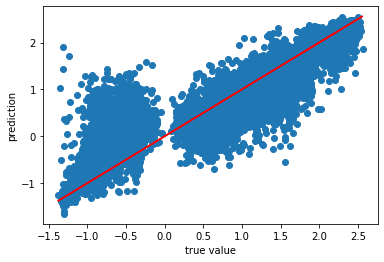

In [84]:
fit_and_eval(CatBoostRegressor(), n2_X_train, n2_y_train, n2_X_val, n2_y_val)

#### 4.5.6 3JHC

Learning rate set to 0.125661
0:	learn: 0.6115544	total: 111ms	remaining: 1m 51s
1:	learn: 0.5907563	total: 198ms	remaining: 1m 38s
2:	learn: 0.5743046	total: 292ms	remaining: 1m 37s
3:	learn: 0.5607318	total: 379ms	remaining: 1m 34s
4:	learn: 0.5500758	total: 469ms	remaining: 1m 33s
5:	learn: 0.5413759	total: 559ms	remaining: 1m 32s
6:	learn: 0.5342266	total: 652ms	remaining: 1m 32s
7:	learn: 0.5283223	total: 739ms	remaining: 1m 31s
8:	learn: 0.5225777	total: 833ms	remaining: 1m 31s
9:	learn: 0.5174237	total: 924ms	remaining: 1m 31s
10:	learn: 0.5128575	total: 1.01s	remaining: 1m 30s
11:	learn: 0.5085166	total: 1.09s	remaining: 1m 29s
12:	learn: 0.5059511	total: 1.18s	remaining: 1m 29s
13:	learn: 0.5024579	total: 1.27s	remaining: 1m 29s
14:	learn: 0.4988801	total: 1.36s	remaining: 1m 29s
15:	learn: 0.4962008	total: 1.46s	remaining: 1m 29s
16:	learn: 0.4937589	total: 1.54s	remaining: 1m 29s
17:	learn: 0.4914755	total: 1.64s	remaining: 1m 29s
18:	learn: 0.4900274	total: 1.73s	remaining:

158:	learn: 0.4324358	total: 13.6s	remaining: 1m 12s
159:	learn: 0.4323495	total: 13.7s	remaining: 1m 12s
160:	learn: 0.4320395	total: 13.8s	remaining: 1m 11s
161:	learn: 0.4318185	total: 13.9s	remaining: 1m 11s
162:	learn: 0.4316406	total: 14s	remaining: 1m 11s
163:	learn: 0.4314510	total: 14.1s	remaining: 1m 11s
164:	learn: 0.4313861	total: 14.2s	remaining: 1m 11s
165:	learn: 0.4311311	total: 14.3s	remaining: 1m 11s
166:	learn: 0.4309568	total: 14.3s	remaining: 1m 11s
167:	learn: 0.4308130	total: 14.4s	remaining: 1m 11s
168:	learn: 0.4306768	total: 14.5s	remaining: 1m 11s
169:	learn: 0.4305074	total: 14.6s	remaining: 1m 11s
170:	learn: 0.4303305	total: 14.7s	remaining: 1m 11s
171:	learn: 0.4302371	total: 14.8s	remaining: 1m 11s
172:	learn: 0.4300162	total: 14.9s	remaining: 1m 11s
173:	learn: 0.4297369	total: 14.9s	remaining: 1m 10s
174:	learn: 0.4295971	total: 15s	remaining: 1m 10s
175:	learn: 0.4294033	total: 15.1s	remaining: 1m 10s
176:	learn: 0.4293117	total: 15.2s	remaining: 1m 1

318:	learn: 0.4139706	total: 26.9s	remaining: 57.4s
319:	learn: 0.4139041	total: 26.9s	remaining: 57.3s
320:	learn: 0.4138052	total: 27s	remaining: 57.2s
321:	learn: 0.4136522	total: 27.1s	remaining: 57.1s
322:	learn: 0.4136038	total: 27.2s	remaining: 57s
323:	learn: 0.4135223	total: 27.3s	remaining: 57s
324:	learn: 0.4133921	total: 27.4s	remaining: 56.9s
325:	learn: 0.4133476	total: 27.5s	remaining: 56.8s
326:	learn: 0.4132646	total: 27.5s	remaining: 56.7s
327:	learn: 0.4132104	total: 27.6s	remaining: 56.6s
328:	learn: 0.4131560	total: 27.7s	remaining: 56.5s
329:	learn: 0.4130706	total: 27.8s	remaining: 56.4s
330:	learn: 0.4130015	total: 27.9s	remaining: 56.3s
331:	learn: 0.4129650	total: 28s	remaining: 56.3s
332:	learn: 0.4128457	total: 28.1s	remaining: 56.2s
333:	learn: 0.4127812	total: 28.1s	remaining: 56.1s
334:	learn: 0.4126871	total: 28.2s	remaining: 56s
335:	learn: 0.4126443	total: 28.3s	remaining: 55.9s
336:	learn: 0.4125963	total: 28.4s	remaining: 55.9s
337:	learn: 0.4125422	

479:	learn: 0.4029474	total: 40.4s	remaining: 43.8s
480:	learn: 0.4028791	total: 40.5s	remaining: 43.7s
481:	learn: 0.4027729	total: 40.6s	remaining: 43.6s
482:	learn: 0.4027022	total: 40.6s	remaining: 43.5s
483:	learn: 0.4025622	total: 40.7s	remaining: 43.4s
484:	learn: 0.4025031	total: 40.8s	remaining: 43.3s
485:	learn: 0.4024476	total: 40.9s	remaining: 43.2s
486:	learn: 0.4023970	total: 41s	remaining: 43.2s
487:	learn: 0.4023482	total: 41s	remaining: 43.1s
488:	learn: 0.4023120	total: 41.1s	remaining: 43s
489:	learn: 0.4022667	total: 41.2s	remaining: 42.9s
490:	learn: 0.4022347	total: 41.3s	remaining: 42.8s
491:	learn: 0.4021580	total: 41.4s	remaining: 42.7s
492:	learn: 0.4021261	total: 41.5s	remaining: 42.7s
493:	learn: 0.4020699	total: 41.6s	remaining: 42.6s
494:	learn: 0.4018885	total: 41.6s	remaining: 42.5s
495:	learn: 0.4018355	total: 41.7s	remaining: 42.4s
496:	learn: 0.4017152	total: 41.8s	remaining: 42.3s
497:	learn: 0.4016963	total: 41.9s	remaining: 42.2s
498:	learn: 0.4016

638:	learn: 0.3953072	total: 53.5s	remaining: 30.2s
639:	learn: 0.3952628	total: 53.6s	remaining: 30.1s
640:	learn: 0.3952343	total: 53.7s	remaining: 30.1s
641:	learn: 0.3952092	total: 53.8s	remaining: 30s
642:	learn: 0.3951721	total: 53.8s	remaining: 29.9s
643:	learn: 0.3951143	total: 53.9s	remaining: 29.8s
644:	learn: 0.3950863	total: 54s	remaining: 29.7s
645:	learn: 0.3950150	total: 54.1s	remaining: 29.6s
646:	learn: 0.3949829	total: 54.2s	remaining: 29.5s
647:	learn: 0.3949521	total: 54.2s	remaining: 29.5s
648:	learn: 0.3949198	total: 54.3s	remaining: 29.4s
649:	learn: 0.3948863	total: 54.4s	remaining: 29.3s
650:	learn: 0.3948481	total: 54.5s	remaining: 29.2s
651:	learn: 0.3948086	total: 54.6s	remaining: 29.1s
652:	learn: 0.3947697	total: 54.6s	remaining: 29s
653:	learn: 0.3947254	total: 54.7s	remaining: 29s
654:	learn: 0.3946838	total: 54.8s	remaining: 28.9s
655:	learn: 0.3946388	total: 54.9s	remaining: 28.8s
656:	learn: 0.3946033	total: 55s	remaining: 28.7s
657:	learn: 0.3945686	

800:	learn: 0.3894476	total: 1m 7s	remaining: 16.7s
801:	learn: 0.3894105	total: 1m 7s	remaining: 16.6s
802:	learn: 0.3893893	total: 1m 7s	remaining: 16.5s
803:	learn: 0.3893432	total: 1m 7s	remaining: 16.4s
804:	learn: 0.3893197	total: 1m 7s	remaining: 16.4s
805:	learn: 0.3892840	total: 1m 7s	remaining: 16.3s
806:	learn: 0.3892632	total: 1m 7s	remaining: 16.2s
807:	learn: 0.3892303	total: 1m 7s	remaining: 16.1s
808:	learn: 0.3891981	total: 1m 7s	remaining: 16s
809:	learn: 0.3891776	total: 1m 7s	remaining: 15.9s
810:	learn: 0.3891521	total: 1m 7s	remaining: 15.8s
811:	learn: 0.3891286	total: 1m 8s	remaining: 15.8s
812:	learn: 0.3890845	total: 1m 8s	remaining: 15.7s
813:	learn: 0.3890725	total: 1m 8s	remaining: 15.6s
814:	learn: 0.3890457	total: 1m 8s	remaining: 15.5s
815:	learn: 0.3889990	total: 1m 8s	remaining: 15.4s
816:	learn: 0.3889689	total: 1m 8s	remaining: 15.3s
817:	learn: 0.3889236	total: 1m 8s	remaining: 15.3s
818:	learn: 0.3889068	total: 1m 8s	remaining: 15.2s
819:	learn: 0.

958:	learn: 0.3845911	total: 1m 20s	remaining: 3.42s
959:	learn: 0.3845715	total: 1m 20s	remaining: 3.34s
960:	learn: 0.3845522	total: 1m 20s	remaining: 3.26s
961:	learn: 0.3845002	total: 1m 20s	remaining: 3.17s
962:	learn: 0.3844760	total: 1m 20s	remaining: 3.09s
963:	learn: 0.3844510	total: 1m 20s	remaining: 3s
964:	learn: 0.3844047	total: 1m 20s	remaining: 2.92s
965:	learn: 0.3843595	total: 1m 20s	remaining: 2.84s
966:	learn: 0.3843376	total: 1m 20s	remaining: 2.75s
967:	learn: 0.3843116	total: 1m 20s	remaining: 2.67s
968:	learn: 0.3842928	total: 1m 20s	remaining: 2.59s
969:	learn: 0.3842659	total: 1m 20s	remaining: 2.5s
970:	learn: 0.3842504	total: 1m 21s	remaining: 2.42s
971:	learn: 0.3842224	total: 1m 21s	remaining: 2.34s
972:	learn: 0.3841981	total: 1m 21s	remaining: 2.25s
973:	learn: 0.3841680	total: 1m 21s	remaining: 2.17s
974:	learn: 0.3841438	total: 1m 21s	remaining: 2.09s
975:	learn: 0.3841143	total: 1m 21s	remaining: 2s
976:	learn: 0.3840978	total: 1m 21s	remaining: 1.92s


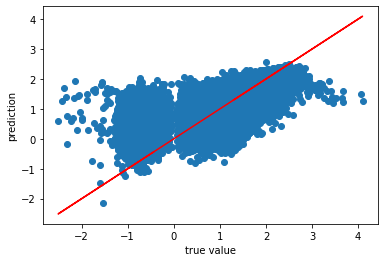

In [85]:
fit_and_eval(CatBoostRegressor(), c3_X_train, c3_y_train, c3_X_val, c3_y_val)

#### 4.5.7 3JHH

Learning rate set to 0.108324
0:	learn: 0.6579496	total: 56.4ms	remaining: 56.3s
1:	learn: 0.6127517	total: 98.6ms	remaining: 49.2s
2:	learn: 0.5743288	total: 140ms	remaining: 46.5s
3:	learn: 0.5412172	total: 184ms	remaining: 45.9s
4:	learn: 0.5122360	total: 229ms	remaining: 45.5s
5:	learn: 0.4866620	total: 271ms	remaining: 44.9s
6:	learn: 0.4640494	total: 315ms	remaining: 44.7s
7:	learn: 0.4443802	total: 359ms	remaining: 44.5s
8:	learn: 0.4274427	total: 400ms	remaining: 44s
9:	learn: 0.4126852	total: 441ms	remaining: 43.6s
10:	learn: 0.4000689	total: 480ms	remaining: 43.1s
11:	learn: 0.3884808	total: 518ms	remaining: 42.7s
12:	learn: 0.3793515	total: 557ms	remaining: 42.3s
13:	learn: 0.3711076	total: 600ms	remaining: 42.3s
14:	learn: 0.3640244	total: 641ms	remaining: 42.1s
15:	learn: 0.3581923	total: 681ms	remaining: 41.9s
16:	learn: 0.3526579	total: 721ms	remaining: 41.7s
17:	learn: 0.3476936	total: 763ms	remaining: 41.6s
18:	learn: 0.3436033	total: 801ms	remaining: 41.3s
19:	learn: 

165:	learn: 0.2524285	total: 6.21s	remaining: 31.2s
166:	learn: 0.2521813	total: 6.25s	remaining: 31.2s
167:	learn: 0.2521116	total: 6.28s	remaining: 31.1s
168:	learn: 0.2519847	total: 6.31s	remaining: 31s
169:	learn: 0.2518767	total: 6.34s	remaining: 31s
170:	learn: 0.2516635	total: 6.38s	remaining: 30.9s
171:	learn: 0.2513819	total: 6.42s	remaining: 30.9s
172:	learn: 0.2510214	total: 6.45s	remaining: 30.8s
173:	learn: 0.2509568	total: 6.48s	remaining: 30.8s
174:	learn: 0.2508565	total: 6.51s	remaining: 30.7s
175:	learn: 0.2507943	total: 6.55s	remaining: 30.7s
176:	learn: 0.2506721	total: 6.59s	remaining: 30.7s
177:	learn: 0.2503736	total: 6.63s	remaining: 30.6s
178:	learn: 0.2502444	total: 6.67s	remaining: 30.6s
179:	learn: 0.2500789	total: 6.7s	remaining: 30.5s
180:	learn: 0.2499997	total: 6.74s	remaining: 30.5s
181:	learn: 0.2497117	total: 6.78s	remaining: 30.5s
182:	learn: 0.2495051	total: 6.81s	remaining: 30.4s
183:	learn: 0.2492386	total: 6.84s	remaining: 30.4s
184:	learn: 0.249

328:	learn: 0.2338133	total: 12.3s	remaining: 25s
329:	learn: 0.2337713	total: 12.3s	remaining: 24.9s
330:	learn: 0.2337358	total: 12.3s	remaining: 24.9s
331:	learn: 0.2337078	total: 12.4s	remaining: 24.9s
332:	learn: 0.2336691	total: 12.4s	remaining: 24.8s
333:	learn: 0.2336070	total: 12.4s	remaining: 24.8s
334:	learn: 0.2336021	total: 12.5s	remaining: 24.7s
335:	learn: 0.2335597	total: 12.5s	remaining: 24.7s
336:	learn: 0.2335117	total: 12.5s	remaining: 24.6s
337:	learn: 0.2334375	total: 12.6s	remaining: 24.6s
338:	learn: 0.2333808	total: 12.6s	remaining: 24.5s
339:	learn: 0.2333538	total: 12.6s	remaining: 24.5s
340:	learn: 0.2332830	total: 12.6s	remaining: 24.4s
341:	learn: 0.2332411	total: 12.7s	remaining: 24.4s
342:	learn: 0.2332205	total: 12.7s	remaining: 24.4s
343:	learn: 0.2332173	total: 12.8s	remaining: 24.3s
344:	learn: 0.2331228	total: 12.8s	remaining: 24.3s
345:	learn: 0.2329154	total: 12.8s	remaining: 24.3s
346:	learn: 0.2327635	total: 12.9s	remaining: 24.2s
347:	learn: 0.

489:	learn: 0.2230767	total: 18.1s	remaining: 18.8s
490:	learn: 0.2230567	total: 18.1s	remaining: 18.8s
491:	learn: 0.2229922	total: 18.1s	remaining: 18.7s
492:	learn: 0.2229663	total: 18.2s	remaining: 18.7s
493:	learn: 0.2228465	total: 18.2s	remaining: 18.7s
494:	learn: 0.2227921	total: 18.3s	remaining: 18.6s
495:	learn: 0.2226683	total: 18.3s	remaining: 18.6s
496:	learn: 0.2225539	total: 18.3s	remaining: 18.5s
497:	learn: 0.2225067	total: 18.4s	remaining: 18.5s
498:	learn: 0.2223434	total: 18.4s	remaining: 18.5s
499:	learn: 0.2223039	total: 18.4s	remaining: 18.4s
500:	learn: 0.2221811	total: 18.5s	remaining: 18.4s
501:	learn: 0.2221555	total: 18.5s	remaining: 18.4s
502:	learn: 0.2220294	total: 18.5s	remaining: 18.3s
503:	learn: 0.2219215	total: 18.6s	remaining: 18.3s
504:	learn: 0.2218414	total: 18.6s	remaining: 18.2s
505:	learn: 0.2216920	total: 18.6s	remaining: 18.2s
506:	learn: 0.2216607	total: 18.7s	remaining: 18.2s
507:	learn: 0.2216291	total: 18.7s	remaining: 18.1s
508:	learn: 

649:	learn: 0.2154053	total: 23.8s	remaining: 12.8s
650:	learn: 0.2153627	total: 23.8s	remaining: 12.8s
651:	learn: 0.2153514	total: 23.9s	remaining: 12.7s
652:	learn: 0.2152787	total: 23.9s	remaining: 12.7s
653:	learn: 0.2152561	total: 23.9s	remaining: 12.7s
654:	learn: 0.2152344	total: 24s	remaining: 12.6s
655:	learn: 0.2151922	total: 24s	remaining: 12.6s
656:	learn: 0.2151618	total: 24s	remaining: 12.6s
657:	learn: 0.2151434	total: 24.1s	remaining: 12.5s
658:	learn: 0.2151342	total: 24.1s	remaining: 12.5s
659:	learn: 0.2150882	total: 24.1s	remaining: 12.4s
660:	learn: 0.2150675	total: 24.2s	remaining: 12.4s
661:	learn: 0.2150479	total: 24.2s	remaining: 12.4s
662:	learn: 0.2149180	total: 24.3s	remaining: 12.3s
663:	learn: 0.2149036	total: 24.3s	remaining: 12.3s
664:	learn: 0.2148851	total: 24.3s	remaining: 12.3s
665:	learn: 0.2148610	total: 24.4s	remaining: 12.2s
666:	learn: 0.2148010	total: 24.4s	remaining: 12.2s
667:	learn: 0.2147505	total: 24.4s	remaining: 12.1s
668:	learn: 0.2147

809:	learn: 0.2100244	total: 29.5s	remaining: 6.92s
810:	learn: 0.2099755	total: 29.6s	remaining: 6.89s
811:	learn: 0.2099673	total: 29.6s	remaining: 6.85s
812:	learn: 0.2099411	total: 29.6s	remaining: 6.82s
813:	learn: 0.2099156	total: 29.7s	remaining: 6.78s
814:	learn: 0.2098893	total: 29.7s	remaining: 6.74s
815:	learn: 0.2098744	total: 29.7s	remaining: 6.71s
816:	learn: 0.2098479	total: 29.8s	remaining: 6.67s
817:	learn: 0.2098231	total: 29.8s	remaining: 6.63s
818:	learn: 0.2098090	total: 29.9s	remaining: 6.6s
819:	learn: 0.2097740	total: 29.9s	remaining: 6.56s
820:	learn: 0.2097304	total: 29.9s	remaining: 6.52s
821:	learn: 0.2097081	total: 30s	remaining: 6.49s
822:	learn: 0.2096888	total: 30s	remaining: 6.45s
823:	learn: 0.2096208	total: 30s	remaining: 6.41s
824:	learn: 0.2096066	total: 30.1s	remaining: 6.38s
825:	learn: 0.2095530	total: 30.1s	remaining: 6.34s
826:	learn: 0.2095422	total: 30.1s	remaining: 6.3s
827:	learn: 0.2095296	total: 30.2s	remaining: 6.27s
828:	learn: 0.209509

969:	learn: 0.2049345	total: 35.3s	remaining: 1.09s
970:	learn: 0.2048870	total: 35.3s	remaining: 1.05s
971:	learn: 0.2048665	total: 35.4s	remaining: 1.02s
972:	learn: 0.2048393	total: 35.4s	remaining: 982ms
973:	learn: 0.2048067	total: 35.4s	remaining: 946ms
974:	learn: 0.2047793	total: 35.5s	remaining: 909ms
975:	learn: 0.2047758	total: 35.5s	remaining: 873ms
976:	learn: 0.2047164	total: 35.5s	remaining: 837ms
977:	learn: 0.2046448	total: 35.6s	remaining: 801ms
978:	learn: 0.2046057	total: 35.6s	remaining: 764ms
979:	learn: 0.2045470	total: 35.7s	remaining: 728ms
980:	learn: 0.2045150	total: 35.7s	remaining: 692ms
981:	learn: 0.2044455	total: 35.7s	remaining: 655ms
982:	learn: 0.2044303	total: 35.8s	remaining: 619ms
983:	learn: 0.2043641	total: 35.8s	remaining: 582ms
984:	learn: 0.2043499	total: 35.9s	remaining: 546ms
985:	learn: 0.2043151	total: 35.9s	remaining: 510ms
986:	learn: 0.2042993	total: 35.9s	remaining: 473ms
987:	learn: 0.2042820	total: 36s	remaining: 437ms
988:	learn: 0.

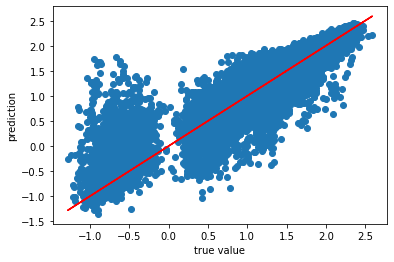

In [86]:
fit_and_eval(CatBoostRegressor(), h3_X_train, h3_y_train, h3_X_val, h3_y_val)

#### 4.5.8 3JHN

Learning rate set to 0.088695
0:	learn: 0.6840591	total: 14.3ms	remaining: 14.3s
1:	learn: 0.6706310	total: 26.9ms	remaining: 13.4s
2:	learn: 0.6594255	total: 39.8ms	remaining: 13.2s
3:	learn: 0.6491629	total: 52.6ms	remaining: 13.1s
4:	learn: 0.6411549	total: 64.5ms	remaining: 12.8s
5:	learn: 0.6333296	total: 77.9ms	remaining: 12.9s
6:	learn: 0.6255524	total: 90.6ms	remaining: 12.9s
7:	learn: 0.6191096	total: 102ms	remaining: 12.7s
8:	learn: 0.6131508	total: 115ms	remaining: 12.7s
9:	learn: 0.6079201	total: 127ms	remaining: 12.6s
10:	learn: 0.6029577	total: 140ms	remaining: 12.6s
11:	learn: 0.5984484	total: 154ms	remaining: 12.7s
12:	learn: 0.5938424	total: 169ms	remaining: 12.9s
13:	learn: 0.5894772	total: 184ms	remaining: 12.9s
14:	learn: 0.5848290	total: 198ms	remaining: 13s
15:	learn: 0.5808868	total: 210ms	remaining: 12.9s
16:	learn: 0.5774543	total: 222ms	remaining: 12.8s
17:	learn: 0.5738429	total: 236ms	remaining: 12.9s
18:	learn: 0.5706149	total: 249ms	remaining: 12.9s
19:	le

163:	learn: 0.4576978	total: 2.14s	remaining: 10.9s
164:	learn: 0.4574184	total: 2.15s	remaining: 10.9s
165:	learn: 0.4572273	total: 2.17s	remaining: 10.9s
166:	learn: 0.4570137	total: 2.18s	remaining: 10.9s
167:	learn: 0.4564971	total: 2.19s	remaining: 10.9s
168:	learn: 0.4560781	total: 2.2s	remaining: 10.8s
169:	learn: 0.4557513	total: 2.22s	remaining: 10.8s
170:	learn: 0.4554320	total: 2.23s	remaining: 10.8s
171:	learn: 0.4551486	total: 2.24s	remaining: 10.8s
172:	learn: 0.4548984	total: 2.25s	remaining: 10.8s
173:	learn: 0.4547727	total: 2.27s	remaining: 10.8s
174:	learn: 0.4543309	total: 2.28s	remaining: 10.7s
175:	learn: 0.4540256	total: 2.29s	remaining: 10.7s
176:	learn: 0.4538836	total: 2.31s	remaining: 10.7s
177:	learn: 0.4536653	total: 2.32s	remaining: 10.7s
178:	learn: 0.4534622	total: 2.33s	remaining: 10.7s
179:	learn: 0.4532060	total: 2.34s	remaining: 10.7s
180:	learn: 0.4529191	total: 2.36s	remaining: 10.7s
181:	learn: 0.4526876	total: 2.37s	remaining: 10.7s
182:	learn: 0

327:	learn: 0.4237268	total: 4.31s	remaining: 8.84s
328:	learn: 0.4236553	total: 4.33s	remaining: 8.82s
329:	learn: 0.4234991	total: 4.34s	remaining: 8.81s
330:	learn: 0.4233028	total: 4.35s	remaining: 8.8s
331:	learn: 0.4231731	total: 4.37s	remaining: 8.78s
332:	learn: 0.4229998	total: 4.38s	remaining: 8.77s
333:	learn: 0.4229197	total: 4.39s	remaining: 8.75s
334:	learn: 0.4226844	total: 4.4s	remaining: 8.74s
335:	learn: 0.4224775	total: 4.42s	remaining: 8.73s
336:	learn: 0.4223357	total: 4.43s	remaining: 8.71s
337:	learn: 0.4221793	total: 4.44s	remaining: 8.7s
338:	learn: 0.4220599	total: 4.46s	remaining: 8.69s
339:	learn: 0.4219775	total: 4.47s	remaining: 8.68s
340:	learn: 0.4218241	total: 4.48s	remaining: 8.66s
341:	learn: 0.4216572	total: 4.5s	remaining: 8.65s
342:	learn: 0.4215187	total: 4.51s	remaining: 8.64s
343:	learn: 0.4213737	total: 4.52s	remaining: 8.62s
344:	learn: 0.4212302	total: 4.53s	remaining: 8.61s
345:	learn: 0.4211154	total: 4.55s	remaining: 8.6s
346:	learn: 0.420

486:	learn: 0.4044844	total: 6.47s	remaining: 6.82s
487:	learn: 0.4043521	total: 6.48s	remaining: 6.8s
488:	learn: 0.4043123	total: 6.5s	remaining: 6.79s
489:	learn: 0.4042222	total: 6.51s	remaining: 6.77s
490:	learn: 0.4041376	total: 6.52s	remaining: 6.76s
491:	learn: 0.4040873	total: 6.53s	remaining: 6.74s
492:	learn: 0.4039616	total: 6.54s	remaining: 6.73s
493:	learn: 0.4039021	total: 6.56s	remaining: 6.72s
494:	learn: 0.4038517	total: 6.57s	remaining: 6.7s
495:	learn: 0.4037756	total: 6.58s	remaining: 6.69s
496:	learn: 0.4036630	total: 6.6s	remaining: 6.68s
497:	learn: 0.4035241	total: 6.61s	remaining: 6.66s
498:	learn: 0.4034414	total: 6.62s	remaining: 6.65s
499:	learn: 0.4033346	total: 6.64s	remaining: 6.64s
500:	learn: 0.4032594	total: 6.65s	remaining: 6.62s
501:	learn: 0.4031780	total: 6.66s	remaining: 6.61s
502:	learn: 0.4031187	total: 6.67s	remaining: 6.6s
503:	learn: 0.4029963	total: 6.69s	remaining: 6.58s
504:	learn: 0.4029181	total: 6.7s	remaining: 6.57s
505:	learn: 0.4028

652:	learn: 0.3906244	total: 8.63s	remaining: 4.58s
653:	learn: 0.3905697	total: 8.64s	remaining: 4.57s
654:	learn: 0.3905016	total: 8.65s	remaining: 4.56s
655:	learn: 0.3904468	total: 8.66s	remaining: 4.54s
656:	learn: 0.3903393	total: 8.68s	remaining: 4.53s
657:	learn: 0.3902651	total: 8.69s	remaining: 4.51s
658:	learn: 0.3901405	total: 8.7s	remaining: 4.5s
659:	learn: 0.3900578	total: 8.73s	remaining: 4.5s
660:	learn: 0.3899685	total: 8.74s	remaining: 4.48s
661:	learn: 0.3898509	total: 8.75s	remaining: 4.47s
662:	learn: 0.3897742	total: 8.76s	remaining: 4.45s
663:	learn: 0.3897465	total: 8.78s	remaining: 4.44s
664:	learn: 0.3896548	total: 8.79s	remaining: 4.43s
665:	learn: 0.3895814	total: 8.8s	remaining: 4.42s
666:	learn: 0.3895427	total: 8.82s	remaining: 4.4s
667:	learn: 0.3894710	total: 8.83s	remaining: 4.39s
668:	learn: 0.3893370	total: 8.84s	remaining: 4.38s
669:	learn: 0.3892805	total: 8.86s	remaining: 4.36s
670:	learn: 0.3892364	total: 8.87s	remaining: 4.35s
671:	learn: 0.389

824:	learn: 0.3785924	total: 10.8s	remaining: 2.29s
825:	learn: 0.3785533	total: 10.8s	remaining: 2.28s
826:	learn: 0.3785014	total: 10.8s	remaining: 2.27s
827:	learn: 0.3784231	total: 10.8s	remaining: 2.25s
828:	learn: 0.3783836	total: 10.9s	remaining: 2.24s
829:	learn: 0.3782744	total: 10.9s	remaining: 2.23s
830:	learn: 0.3782065	total: 10.9s	remaining: 2.21s
831:	learn: 0.3781711	total: 10.9s	remaining: 2.2s
832:	learn: 0.3781055	total: 10.9s	remaining: 2.19s
833:	learn: 0.3780310	total: 10.9s	remaining: 2.17s
834:	learn: 0.3779502	total: 10.9s	remaining: 2.16s
835:	learn: 0.3778842	total: 10.9s	remaining: 2.15s
836:	learn: 0.3778342	total: 11s	remaining: 2.13s
837:	learn: 0.3777873	total: 11s	remaining: 2.12s
838:	learn: 0.3777434	total: 11s	remaining: 2.11s
839:	learn: 0.3776484	total: 11s	remaining: 2.09s
840:	learn: 0.3775950	total: 11s	remaining: 2.08s
841:	learn: 0.3775073	total: 11s	remaining: 2.07s
842:	learn: 0.3774538	total: 11s	remaining: 2.06s
843:	learn: 0.3773780	total

987:	learn: 0.3682601	total: 13s	remaining: 158ms
988:	learn: 0.3682018	total: 13s	remaining: 144ms
989:	learn: 0.3681626	total: 13s	remaining: 131ms
990:	learn: 0.3681191	total: 13s	remaining: 118ms
991:	learn: 0.3680309	total: 13s	remaining: 105ms
992:	learn: 0.3679624	total: 13s	remaining: 91.9ms
993:	learn: 0.3678986	total: 13.1s	remaining: 78.8ms
994:	learn: 0.3678482	total: 13.1s	remaining: 65.7ms
995:	learn: 0.3677640	total: 13.1s	remaining: 52.5ms
996:	learn: 0.3677124	total: 13.1s	remaining: 39.4ms
997:	learn: 0.3676563	total: 13.1s	remaining: 26.3ms
998:	learn: 0.3675631	total: 13.1s	remaining: 13.1ms
999:	learn: 0.3675234	total: 13.1s	remaining: 0us
Result Report

Train R2 Score: 0.7233746460904771
Validation R2 Score: 0.6937929612782501

Train RMSE: 0.3675233513905192
Validation RMSE: 0.38300877145517415

Train MAE: 0.2580167524865366
Validation MAE: 0.26673423526379186


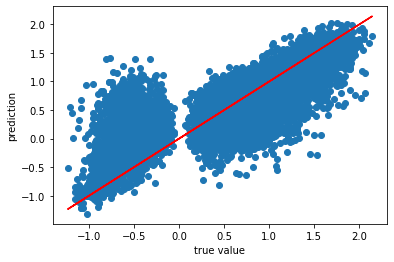

In [87]:
fit_and_eval(CatBoostRegressor(), n3_X_train, n3_y_train, n3_X_val, n3_y_val)

### 4.6 Keras Neural Networks

Last model is Keras neural network model.

In [88]:
def nnet_preprocess(X_train, X_val):    
    '''
    This function preprocess the dataset for the keras neural network. 
    Since the OneHotEncoder creates an error on the dataset for the neural network model, LabelEncoder was used instead.
    
    Input:
    X_train: train dataset for features (X)
    X_val: validation dataset for features (X)
    
    Output:
    preprocessed version of X_train and X_val
    '''
    # Instantiate the lists of numerical and catergorical column
    num_cols = []
    cat_cols = []
    
    # Divide columns in the dataframe to numerical and categorical
    for c in X_train.columns:
        if X_train[c].dtype in ['float64', 'int64']:
            num_cols.append(c)
        else:
            cat_cols.append(c)
    
    # Instantiate encoder/scaler
    scaler = MinMaxScaler()
    encoder = LabelEncoder()

    # Scale and Encode Separated Columns
    for i in num_cols:
        X_train[[i]] = scaler.fit_transform(X_train[[i]]) 
        X_val[[i]]  = scaler.transform(X_val[[i]]) 
    
    for f in cat_cols:
        X_train[f] = encoder.fit_transform(X_train[[f]])
        X_val[f] = encoder.transform(X_val[[f]])
    
    return X_train, X_val
    

We will use LeakyReLU for the activation.

In [96]:
def fit_eval_nn(X_train, y_train, X_val, y_val, epoch, batch):
    '''
    This function:
    1. Creates the sequential keras model with multiple layers
    2. Compile and fit the model
    3. Make prediction based on the fitted model
    4. Report the results for evaluation (R2 Score, Root Mean Squared Error(RMSE), Mean Absolute Error(MAE))
    5. Plot the scatter plot for the validation prediction and best fit line
    6. Plot the loss curve for the model training procedure
    
    Input:
    X_train: train dataset for features (X)
    y_train: train dataset for target variable (y)
    X_val: validation dataset for features (X)
    y_val: validation dataset for target variable (y)  
    epoch: integer for epochs
    batch: integer for batch size
    
    Output:
    Result Report
    Scatter Plot
    Loss Plot
    history: record of model fitting process 
    
    '''
    # Create Sequential model 
    # Each layer will have LeakyReLU as activation and BatchNormalization
    model = Sequential()
    model.add(Dense(256, input_shape = (15,)))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))    
    # Output layer
    model.add(Dense(1,activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error',optimizer= Adam(1e-4), metrics=['mae'])
    
    # Preprocess the train and validation set for the fitting
    X_train, X_val = nnet_preprocess(X_train, X_val)
    
    # Define early_stopping
    early_stopping = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2)
    
    # Fit model
    history = model.fit(X_train, y_train, 
                        validation_data=(X_val, y_val), 
                        epochs = epoch, 
                        batch_size = batch,
                        callbacks = early_stopping)
    
    # Prediction based on the fitted model 
    tr_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    # Report Results (R2, RMSE, MAE) 
    print('Result Report')
    print('')
    print(f'Train R2 Score: {r2_score(y_train, tr_pred)}')
    print(f'Validation R2 Score: {r2_score(y_val, val_pred)}')
    print('')
    print(f'Train RMSE: {mean_squared_error(y_train, tr_pred, squared = False)}')
    print(f'Validation RMSE: {mean_squared_error(y_val, val_pred, squared = False)}')
    print('')
    print(f'Validation MAE: {mean_absolute_error(y_train, tr_pred)}')
    print(f'Validation MAE: {mean_absolute_error(y_val, val_pred)}')
    print('')
    
    # Plot the fitted line and the prediction
    print('Prediction')
    plt.scatter(y_val,val_pred)
    plt.plot(y_val, y_val, c="Red")
    plt.xlabel('true value')
    plt.ylabel('prediction')
    plt.show()
    print('')
    
    # Plot the loss curve 
    print('Loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()
    
    # Return history of  the fitted model
    return history

Batch sizes are determined based on the training time. Training time was aimed to be less than or equal to 1 min per epoch while maintaining more than 1000 iterations per epoch.

#### 4.6.1 1JHC

Epoch 1/100
4433/4433 [==============================] - 66s 15ms/step - loss: 4.9556 - mae: 1.6530 - val_loss: 0.0303 - val_mae: 0.1322
Epoch 2/100
4433/4433 [==============================] - 72s 16ms/step - loss: 0.4185 - mae: 0.4846 - val_loss: 0.0158 - val_mae: 0.0909
Epoch 3/100
4433/4433 [==============================] - 72s 16ms/step - loss: 0.1951 - mae: 0.3286 - val_loss: 0.0135 - val_mae: 0.0829
Epoch 4/100
4433/4433 [==============================] - 72s 16ms/step - loss: 0.1064 - mae: 0.2436 - val_loss: 0.0118 - val_mae: 0.0786
Epoch 5/100
4433/4433 [==============================] - 72s 16ms/step - loss: 0.0704 - mae: 0.2030 - val_loss: 0.0117 - val_mae: 0.0771
Epoch 6/100
4433/4433 [==============================] - 73s 16ms/step - loss: 0.0531 - mae: 0.1790 - val_loss: 0.0110 - val_mae: 0.0740
Epoch 7/100
4433/4433 [==============================] - 71s 16ms/step - loss: 0.0442 - mae: 0.1644 - val_loss: 0.0112 - val_mae: 0.0739
Epoch 8/100
4433/4433 [==================

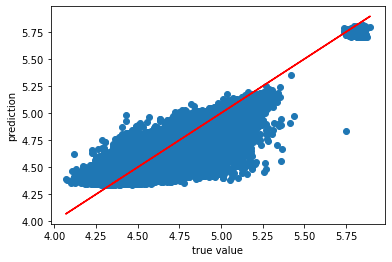


Loss


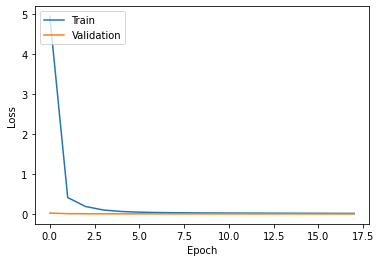

In [97]:
history1 = fit_eval_nn(c1_X_train, c1_y_train, c1_X_val, c1_y_val, epoch = 100, batch = 128)

#### 4.6.2 1JHN

Epoch 1/100
1092/1092 [==============================] - 11s 10ms/step - loss: 9.5999 - mae: 2.9670 - val_loss: 4.6543 - val_mae: 2.1394
Epoch 2/100
1092/1092 [==============================] - 9s 8ms/step - loss: 2.4831 - mae: 1.3488 - val_loss: 0.2708 - val_mae: 0.4771
Epoch 3/100
1092/1092 [==============================] - 9s 8ms/step - loss: 0.6701 - mae: 0.6240 - val_loss: 0.0387 - val_mae: 0.1595
Epoch 4/100
1092/1092 [==============================] - 10s 9ms/step - loss: 0.5285 - mae: 0.5482 - val_loss: 0.0285 - val_mae: 0.1354
Epoch 5/100
1092/1092 [==============================] - 9s 8ms/step - loss: 0.4528 - mae: 0.5056 - val_loss: 0.0223 - val_mae: 0.1158
Epoch 6/100
1092/1092 [==============================] - 9s 8ms/step - loss: 0.3879 - mae: 0.4679 - val_loss: 0.0178 - val_mae: 0.1043
Epoch 7/100
1092/1092 [==============================] - 9s 8ms/step - loss: 0.3293 - mae: 0.4299 - val_loss: 0.0138 - val_mae: 0.0898
Epoch 8/100
1092/1092 [=============================

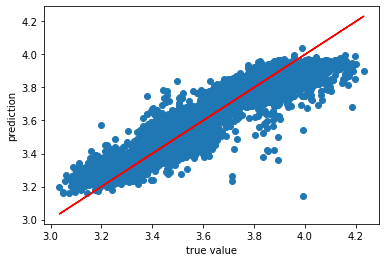


Loss


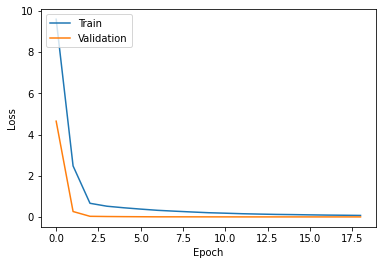

In [98]:
history2 = fit_eval_nn(n1_X_train, n1_y_train, n1_X_val, n1_y_val, epoch = 100, batch = 32)

#### 4.6.3 2JHC

Epoch 1/100
1783/1783 [==============================] - 84s 47ms/step - loss: 1.3258 - mae: 0.9212 - val_loss: 0.9285 - val_mae: 0.7343
Epoch 2/100
1783/1783 [==============================] - 84s 47ms/step - loss: 1.0338 - mae: 0.7999 - val_loss: 0.8417 - val_mae: 0.6865
Epoch 3/100
1783/1783 [==============================] - 84s 47ms/step - loss: 0.9189 - mae: 0.7431 - val_loss: 0.7843 - val_mae: 0.6632
Epoch 4/100
1783/1783 [==============================] - 85s 48ms/step - loss: 0.8516 - mae: 0.7076 - val_loss: 0.7457 - val_mae: 0.6332
Epoch 5/100
1783/1783 [==============================] - 84s 47ms/step - loss: 0.8122 - mae: 0.6849 - val_loss: 0.7250 - val_mae: 0.6248
Epoch 6/100
1783/1783 [==============================] - 84s 47ms/step - loss: 0.7848 - mae: 0.6686 - val_loss: 0.7157 - val_mae: 0.6180
Epoch 7/100
1783/1783 [==============================] - 85s 48ms/step - loss: 0.7643 - mae: 0.6559 - val_loss: 0.6939 - val_mae: 0.6104
Epoch 8/100
1783/1783 [==================

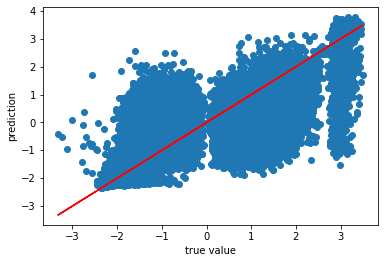


Loss


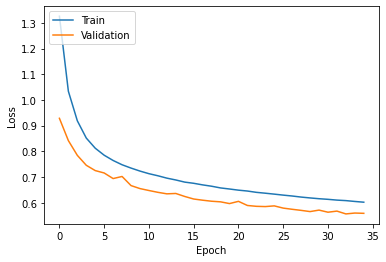

In [99]:
history3 = fit_eval_nn(c2_X_train, c2_y_train, c2_X_val, c2_y_val, epoch = 100, batch = 512)

#### 4.6.4 2JHH

Epoch 1/100
4725/4725 [==============================] - 59s 13ms/step - loss: 1.1013 - mae: 0.7633 - val_loss: 0.1495 - val_mae: 0.1836
Epoch 2/100
4725/4725 [==============================] - 59s 12ms/step - loss: 0.2638 - mae: 0.3468 - val_loss: 0.1266 - val_mae: 0.1432
Epoch 3/100
4725/4725 [==============================] - 58s 12ms/step - loss: 0.1702 - mae: 0.2652 - val_loss: 0.1024 - val_mae: 0.1242
Epoch 4/100
4725/4725 [==============================] - 58s 12ms/step - loss: 0.1316 - mae: 0.2242 - val_loss: 0.0922 - val_mae: 0.1278
Epoch 5/100
4725/4725 [==============================] - 58s 12ms/step - loss: 0.1113 - mae: 0.2002 - val_loss: 0.0783 - val_mae: 0.1169
Epoch 6/100
4725/4725 [==============================] - 59s 12ms/step - loss: 0.0999 - mae: 0.1872 - val_loss: 0.0653 - val_mae: 0.1071
Epoch 7/100
4725/4725 [==============================] - 59s 12ms/step - loss: 0.0919 - mae: 0.1780 - val_loss: 0.0805 - val_mae: 0.1084
Epoch 8/100
4725/4725 [==================

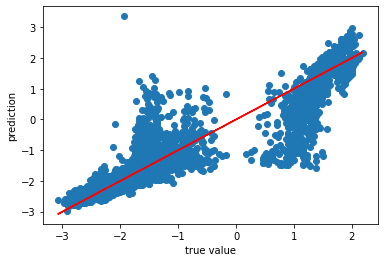


Loss


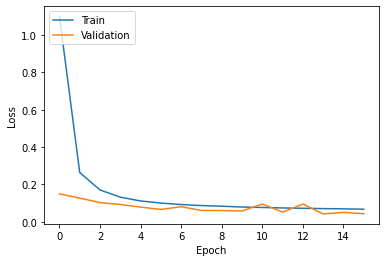

In [100]:
history4 = fit_eval_nn(h2_X_train, h2_y_train, h2_X_val, h2_y_val, epoch = 100, batch = 64)

#### 4.6.5 2JHN

Epoch 1/100
2977/2977 [==============================] - 30s 10ms/step - loss: 1.0556 - mae: 0.8074 - val_loss: 0.4350 - val_mae: 0.4900
Epoch 2/100
2977/2977 [==============================] - 30s 10ms/step - loss: 0.6027 - mae: 0.5956 - val_loss: 0.3427 - val_mae: 0.4309
Epoch 3/100
2977/2977 [==============================] - 29s 10ms/step - loss: 0.4815 - mae: 0.5259 - val_loss: 0.3027 - val_mae: 0.3892
Epoch 4/100
2977/2977 [==============================] - 30s 10ms/step - loss: 0.4187 - mae: 0.4827 - val_loss: 0.2732 - val_mae: 0.3615
Epoch 5/100
2977/2977 [==============================] - 30s 10ms/step - loss: 0.3777 - mae: 0.4539 - val_loss: 0.2555 - val_mae: 0.3419
Epoch 6/100
2977/2977 [==============================] - 30s 10ms/step - loss: 0.3562 - mae: 0.4356 - val_loss: 0.2580 - val_mae: 0.3445
Epoch 7/100
2977/2977 [==============================] - 30s 10ms/step - loss: 0.3374 - mae: 0.4207 - val_loss: 0.2463 - val_mae: 0.3354
Epoch 8/100
2977/2977 [==================

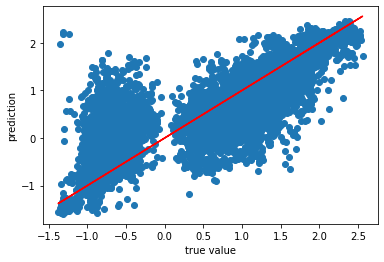


Loss


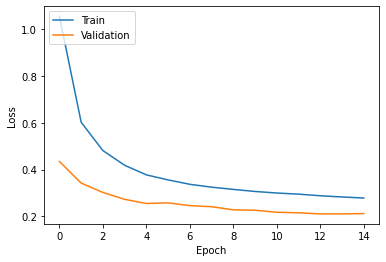

In [101]:
history5 = fit_eval_nn(n2_X_train, n2_y_train, n2_X_val, n2_y_val, epoch = 100, batch = 32)

#### 4.6.6 3JHC

In [102]:
history6 = fit_eval_nn(c3_X_train, c3_y_train, c3_X_val, c3_y_val, epoch = 100, batch = 512)

Epoch 1/100
2362/2362 [==============================] - 117s 49ms/step - loss: 0.8692 - mae: 0.7276 - val_loss: 0.2128 - val_mae: 0.3224
Epoch 2/100
2362/2362 [==============================] - 118s 50ms/step - loss: 0.3282 - mae: 0.4256 - val_loss: 0.1930 - val_mae: 0.2962
Epoch 3/100
2362/2362 [==============================] - 117s 50ms/step - loss: 0.2518 - mae: 0.3619 - val_loss: 0.1860 - val_mae: 0.2876
Epoch 4/100
2362/2362 [==============================] - 117s 49ms/step - loss: 0.2193 - mae: 0.3291 - val_loss: 0.1801 - val_mae: 0.2835
Epoch 5/100
2362/2362 [==============================] - 116s 49ms/step - loss: 0.2037 - mae: 0.3119 - val_loss: 0.1763 - val_mae: 0.2756
Epoch 6/100
2362/2362 [==============================] - 116s 49ms/step - loss: 0.1942 - mae: 0.3014 - val_loss: 0.1702 - val_mae: 0.2721
Epoch 7/100
2362/2362 [==============================] - 116s 49ms/step - loss: 0.1883 - mae: 0.2950 - val_loss: 0.1660 - val_mae: 0.2669
Epoch 8/100
2362/2362 [===========

KeyboardInterrupt: 

#### 4.6.7 3JHH

In [ ]:
history7 = fit_eval_nn(h3_X_train, h3_y_train, h3_X_val, h3_y_val, epoch = 100, batch = 128)

#### 4.6.8 3JHN

In [ ]:
history8 = fit_eval_nn(n3_X_train, n3_y_train, n3_X_val, n3_y_val, epoch = 100, batch = 32)

### 4.7 Final Model

Based on the results, Random Forest is the regressor that shows the best performance. However, there are some bond type that overfits. To reduce the overfit, we will need to go through the hyperparamater tuning.

In [ ]:
# parameters for gridsearch
rf_params={#'classifier__criterion':['squared_error', 'absolute_error', 'poisson'],
           #'classifier__n_estimators':[100, 200, 300],
           #'classifier__min_samples_leaf':[1, 8, 12],
           #'classifier__max_features':['auto','log2', 'sqrt'],
           'classifier__max_depth':[8],
           #'classifier__max_leaf_nodes':[10, 20, 30], 
           #'classifier__min_samples_split' : [2,4,8]
           #'classifier__bootstrap': [True, False]
       }

In [ ]:
def rf_tuning(X_train, y_train, params):
    rf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', RandomForestRegressor())
                        ])
    rf.fit(X_train, y_train)
    grid_rf = GridSearchCV(rf, param_grid=params, scoring= ['neg_root_mean_squared_error'], cv = 3)
    output_rf = grid_rf.fit(X_train, y_train)
    print('Best Param:{0}, Best score:{1:.3f}'.format(grid_rf.best_params_, 
                                               grid_rf.best_score_))

## 5. Evaluation

#### Conclusion

#### Next Step